In [1]:
library(tidyverse) #Use required packages
library(cowplot)

── Attaching packages ──────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [2]:
df_data <- read_csv("framingham_data.csv") # Read in data
df_data %>% summary # Summarize Data


── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  currentSmoker = col_double(),
  sysBP = col_double()
)




 currentSmoker      sysBP      
 Min.   :0.00   Min.   : 90.0  
 1st Qu.:0.00   1st Qu.:118.0  
 Median :0.00   Median :131.8  
 Mean   :0.25   Mean   :134.9  
 3rd Qu.:0.25   3rd Qu.:148.0  
 Max.   :1.00   Max.   :215.0  

In [131]:
df_data$index <- seq(nrow(df_data)) # Add an index column

#Create a sample variance function to ensure proper calculation
sample_variance <- function(x, sampling = TRUE){
    if (sampling == TRUE){
        sum((x - mean(x))^2) / (length(x) - 1)
    } else if(sampling == FALSE) {
        sum((x - mean(x))^2) / (length(x))
    }
}
#Create pooled sample variance function 
f_pooled_variance <- function(x, y){
    ((length(x) - 1) * sample_variance(x) + 
     (length(y) - 1) * sample_variance(y)) / 
    (length(x) + length(y) - 2)
}

df_data %>% summary # Summarize Data

#Split data based on smoking status
df_smoker <- df_data %>% filter(currentSmoker == 1)
df_nonsmoker <- df_data %>% filter(currentSmoker == 0)

 currentSmoker      sysBP           index       
 Min.   :0.00   Min.   : 90.0   Min.   :  1.00  
 1st Qu.:0.00   1st Qu.:118.0   1st Qu.: 75.75  
 Median :0.00   Median :131.8   Median :150.50  
 Mean   :0.25   Mean   :134.9   Mean   :150.50  
 3rd Qu.:0.25   3rd Qu.:148.0   3rd Qu.:225.25  
 Max.   :1.00   Max.   :215.0   Max.   :300.00  

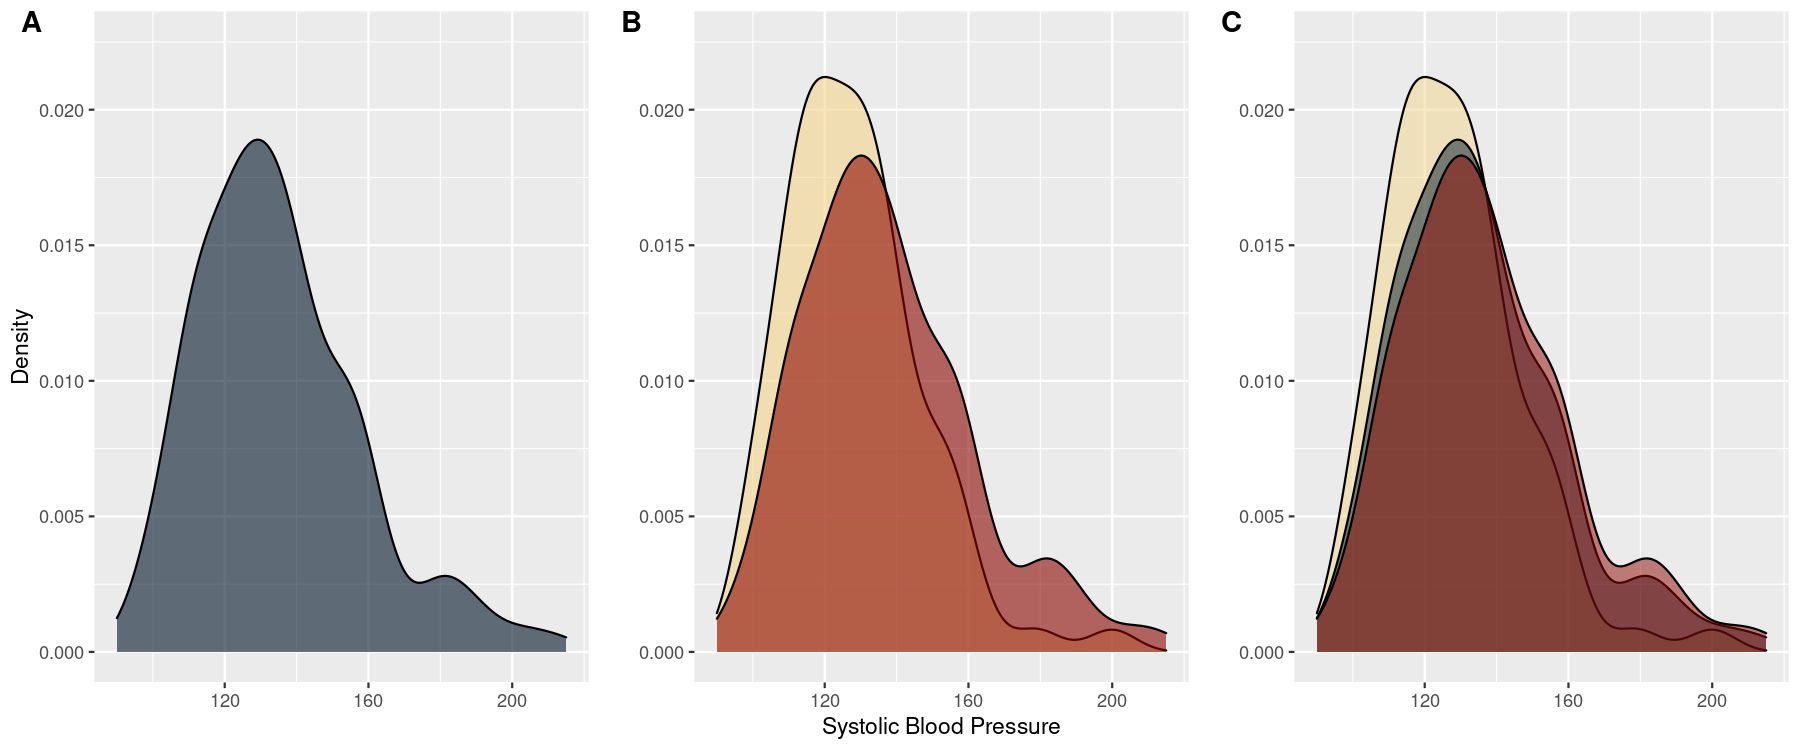

In [4]:
#Plot data

library(cowplot)
options(repr.plot.width = 12, repr.plot.height = 5, repr.plot.res = 150)

plot_colors <- c("#001427","#708d81","#f4d58d","#bf0603","#8d0801")
#plot_colors <- c("#f04b00","#009b00","#1eb4aa","#f7f6f2","#202020")

y_limits <- c(0, 0.0225)

total_data <- ggplot(df_data) + geom_density(aes(sysBP), 
                                             fill = plot_colors[1],
                                             alpha = 0.6) +
                       ylim(y_limits) + ylab("Density") + xlab("")

sep_data <- ggplot() + geom_density(data = df_smoker, aes(sysBP), 
                                    fill = plot_colors[3], alpha = 0.6) + 
                       geom_density(data = df_nonsmoker, aes(sysBP), 
                                    fill = plot_colors[5], alpha = 0.6) +
                       ylim(y_limits) + ylab("") + xlab("Systolic Blood Pressure")

plot_3 <- ggplot() + geom_density(data = df_smoker, aes(sysBP), 
                                    fill = plot_colors[3], alpha = 0.5) + 
                       geom_density(data = df_data, aes(sysBP), 
                                    fill = plot_colors[1], alpha = 0.5) +
                       geom_density(data = df_nonsmoker, aes(sysBP), 
                                    fill = plot_colors[5], alpha = 0.5) +
                       ylim(y_limits) + ylab("") + xlab("")

plot_grid(total_data, sep_data, plot_3, align = 'vh', 
          hjust = -1,nrow = 1, ncol = 3, labels = c("A", "B", "C"))

In [5]:
alpha <- 0.05

mu_smoker <- mean(df_smoker$sysBP)
var_smoker <- sample_variance(df_smoker$sysBP)
n_smoker <- length(df_smoker$sysBP)

mu_nonsmoker <- mean(df_nonsmoker$sysBP)
var_nonsmoker <- sample_variance(df_nonsmoker$sysBP)
n_nonsmoker <- length(df_nonsmoker$sysBP)

dof <- (n_smoker + n_nonsmoker - 2)

p_sample_var <- f_pooled_variance(df_smoker$sysBP, 
                                  df_nonsmoker$sysBP)


t_obs <- (mu_smoker - mu_nonsmoker) / (sqrt(p_sample_var/n_smoker + p_sample_var/n_nonsmoker))

t_stat <- qt(alpha / 2, dof)

p_value_obs <- dt(t_obs, dof)

print(p_sample_var)

print(t_obs)

print(p_value_obs)

print(t_stat)

print(c(var_smoker, var_nonsmoker))

[1] 510.0137
[1] -3.041308
[1] 0.00412984
[1] -1.967957
[1] 352.2117 562.1447


In [6]:
set.seed(1)

alpha <- 0.05

test_function <- function (x, y, pooled = FALSE){
    
    #sample1 <- sample(x, size = length(x), replace = TRUE)#Bootstrap from first data frame
    #sample2 <- sample(y, size = length(y), replace = TRUE)#Bootstrap from second data frame
    sample1 <- x
    sample2 <- y
    
    dof <- length(x) + length(y) - 2 #Determine degrees of freedom
    
    #calculate the mean and variance of the two bootstrap sets
    mu_1 <- mean(sample1)
    var_1 <- sample_variance(sample1, sampling = FALSE)
    
    mu_2 <- mean(sample2)
    var_2 <- sample_variance(sample2, sampling = FALSE)
    
    #Calculate the pooled sample variance
    pooled_sample <- ((length(x) - 1) * var_1 + (length(y) - 1) * var_2) / (length(x) + length(y) - 2)
    
    #calulate the observed t statistic
    if (pooled == TRUE){
        ttest <- (mu_1 - mu_2) / (sqrt(pooled_sample/length(x) + pooled_sample/length(y)))
        } else {
        ttest <- (mu_1 - mu_2) / (sqrt(var_1/length(x) + var_2/length(y)))
    }
    
    #Determine whether or not the null hypothesis can be rejected (1 = rejected, 0 = not rejected)
    verdict <- !between(ttest, qt(alpha / 2, dof), qt(1 - alpha / 2, dof))
    
    #Return calculated values
    return(c(mu_1, var_1, mu_2, var_2, ttest, pooled_sample, verdict))
}

In [7]:
set.seed(1980)

sim_data_results <- rep(0, 7)

for (i in seq(1, 1000)){
    #Run the boot strap a 1000 times and store the results in a matrix
    sim_data_results <- rbind(sim_data_results, test_function(df_nonsmoker$sysBP, df_smoker$sysBP))
}

nrow(sim_data_results)

[1] 1001

In [8]:
#Move data into dataframe for easier processing 

df_sim_data <- data.frame(sim_data_results[2:nrow(sim_data_results),]) 
                          
colnames(df_sim_data) = c("Mean Smoker", "Variance Smoker", "Mean NonSmoker", "Variance NonSmoker", 
                          "T statistic", "Pooled Sample Variance", "Null Reject")

In [9]:
#Calculate the number of scenarios where the null was rejected 
sum(df_sim_data$'Null Reject')

[1] 1000

In [10]:
df_sim_data %>% head

,Mean Smoker,Variance Smoker,Mean NonSmoker,Variance NonSmoker,T statistic,Pooled Sample Variance,Null Reject
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
X,137.2244,559.6463,128.0667,347.5156,3.431816,506.9695,1
X.1,137.2244,559.6463,128.0667,347.5156,3.431816,506.9695,1
X.2,137.2244,559.6463,128.0667,347.5156,3.431816,506.9695,1
X.3,137.2244,559.6463,128.0667,347.5156,3.431816,506.9695,1
X.4,137.2244,559.6463,128.0667,347.5156,3.431816,506.9695,1
X.5,137.2244,559.6463,128.0667,347.5156,3.431816,506.9695,1


In [11]:
str(df_sim_data)

'data.frame':	1000 obs. of  7 variables:
 $ Mean Smoker           : num  137 137 137 137 137 ...
 $ Variance Smoker       : num  560 560 560 560 560 ...
 $ Mean NonSmoker        : num  128 128 128 128 128 ...
 $ Variance NonSmoker    : num  348 348 348 348 348 ...
 $ T statistic           : num  3.43 3.43 3.43 3.43 3.43 ...
 $ Pooled Sample Variance: num  507 507 507 507 507 ...
 $ Null Reject           : num  1 1 1 1 1 1 1 1 1 1 ...


In [12]:
sample_variance <- function(x){
    sum((x - mean(x))^2) / (length(x) - 1)
}

sample_variance(df_data$sysBP)
var(df_data$sysBP)

[1] 524.0852

[1] 524.0852

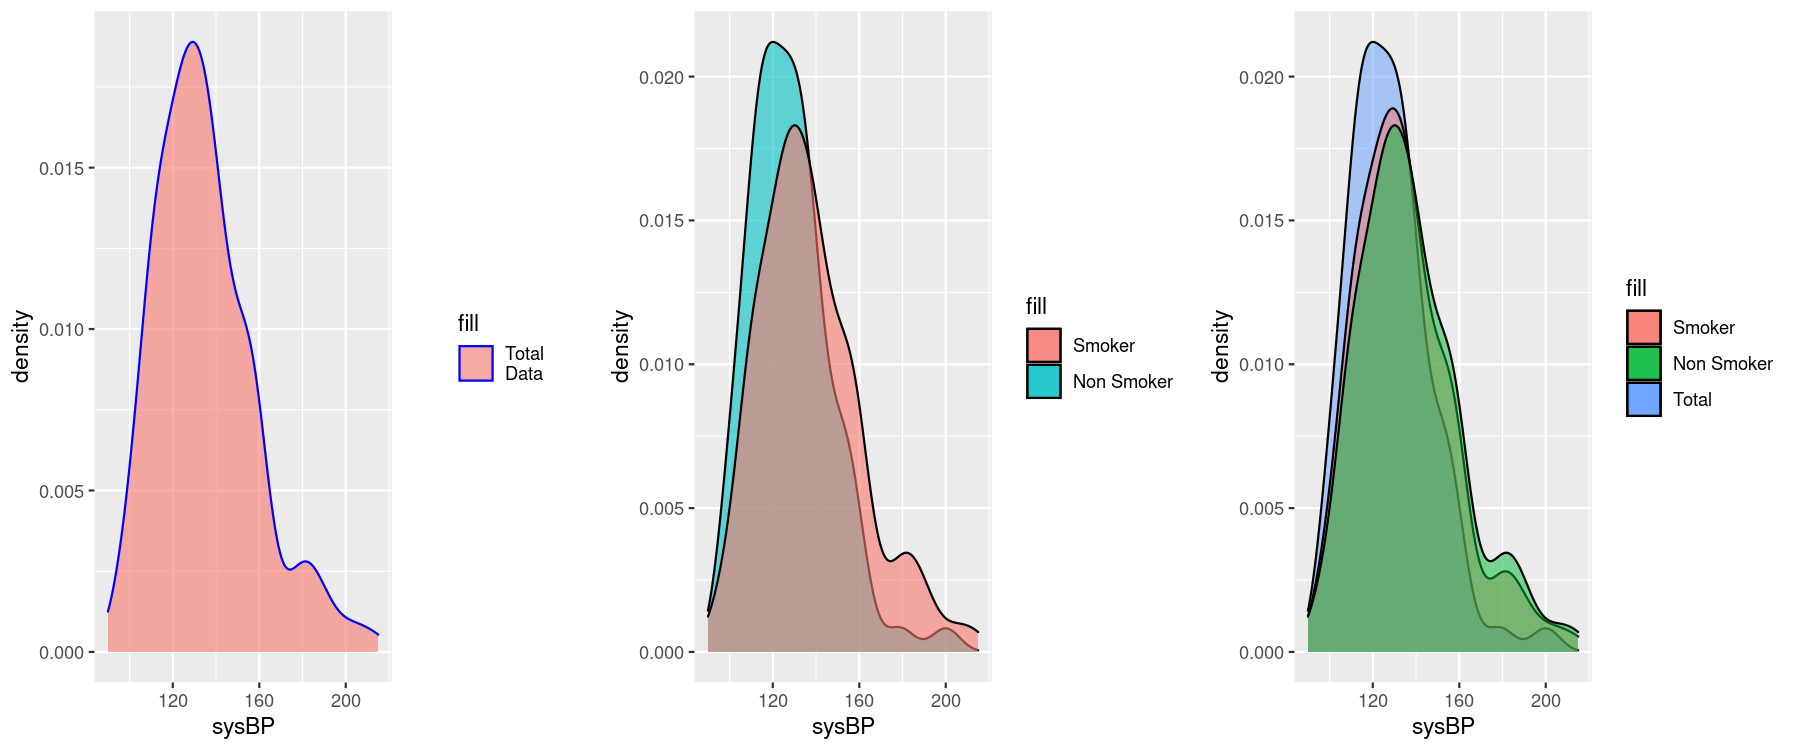

In [13]:
library(cowplot)
options(repr.plot.width = 12, repr.plot.height = 5, repr.plot.res = 150)

total_data <- ggplot(df_data) + geom_density(aes(sysBP, 
                                             fill = "cyan"),
                                             color = "blue",
                                             alpha = 0.6) + scale_fill_hue(labels = c("Total\nData"))

sep_data <- ggplot() + geom_density(data = df_smoker, aes(sysBP, 
                                    fill = "cyan"), alpha = 0.6) + 
                       geom_density(data = df_nonsmoker, aes(sysBP, 
                                    fill = "blue"), alpha = 0.6) + 
                       scale_fill_hue(labels = c("Smoker", "Non Smoker"))

plot_3 <- ggplot() + geom_density(data = df_smoker, aes(sysBP, 
                                    fill = "red"), alpha = 0.5) + 
                       geom_density(data = df_data, aes(sysBP, 
                                    fill = "blue"), alpha = 0.5) +
                       geom_density(data = df_nonsmoker, aes(sysBP, 
                                    fill = "cyan"), alpha = 0.5) +
                       scale_fill_hue(labels = c("Smoker", "Non Smoker", "Total")) 

plot_grid(total_data, sep_data, plot_3, align = 'vh', 
          hjust = -1,nrow = 1, ncol = 3)

In [14]:
library(e1071)
sd(df_data$sysBP)
mean(df_data$sysBP)
kurtosis(df_data$sysBP)
skewness(df_data$sysBP)

[1] 22.89291

[1] 134.935

[1] 0.8123606

[1] 0.8797915

In [15]:
qchisq(0.95, 3)

[1] 7.814728

In [16]:
satterth <- function(s1, s2, n1, n2){
    term1 <- s1/n1
    term2 <- s2/n2
    nu <- (term1 + term2)^2 / ((term1^2/(n1 - 1)) + (term2^2/(n2 - 1)))
    return(floor(nu))
}

In [17]:
satterth(var_smoker, var_nonsmoker, n_smoker, n_nonsmoker)

[1] 158

In [18]:
dof_1 <- (n_smoker + n_nonsmoker - 2)

p_sample_var_1 <- f_pooled_variance(df_smoker$sysBP, 
                                    df_nonsmoker$sysBP)


t_obs_1 <- (mu_smoker - mu_nonsmoker) / (sqrt(p_sample_var_1) * sqrt(1/n_smoker + 1/n_nonsmoker))

t_stat_1 <- qt(alpha / 2, dof_1)

p_value_obs_1 <- dt(t_obs_1, dof_1)

#Two Sample T-test - Difference Variance Sample Variance - P-value

dof_2 <- satterth(var_smoker, var_nonsmoker, n_smoker, n_nonsmoker)

t_obs_2 <- (mu_smoker - mu_nonsmoker) / (sqrt(var_nonsmoker/n_smoker + var_nonsmoker/n_nonsmoker))

t_stat_2 <- qt(alpha / 2, dof_2)

p_value_obs_2 <- dt(t_obs_2, dof_2)

In [39]:
p_sample_var_1/n_smoker + p_sample_var_1/n_nonsmoker

var_nonsmoker/n_smoker + var_nonsmoker/n_nonsmoker
t_obs_1
t_obs_2

[1] 9.06691

[1] 9.993684

[1] -3.041308

[1] -2.896859

In [19]:
# Confidence Limits

diff_mu <- mu_smoker - mu_nonsmoker

#Pooled Sample varince

CI_pooled <- t_stat_1 * (sqrt(p_sample_var_1/n_smoker + p_sample_var_1/n_nonsmoker))

#Non pooled Sample varince

CI_nonpooled <- t_stat_2 * (sqrt(var_nonsmoker/n_smoker + var_nonsmoker/n_nonsmoker))

In [20]:
CI_pooled
CI_nonpooled

[1] -5.925775

[1] -6.243817

In [21]:
round(c(diff_mu + CI_pooled, diff_mu - CI_pooled), 2)

round(c(diff_mu + CI_nonpooled, diff_mu - CI_nonpooled), 2)

[1] -15.08  -3.23

[1] -15.40  -2.91

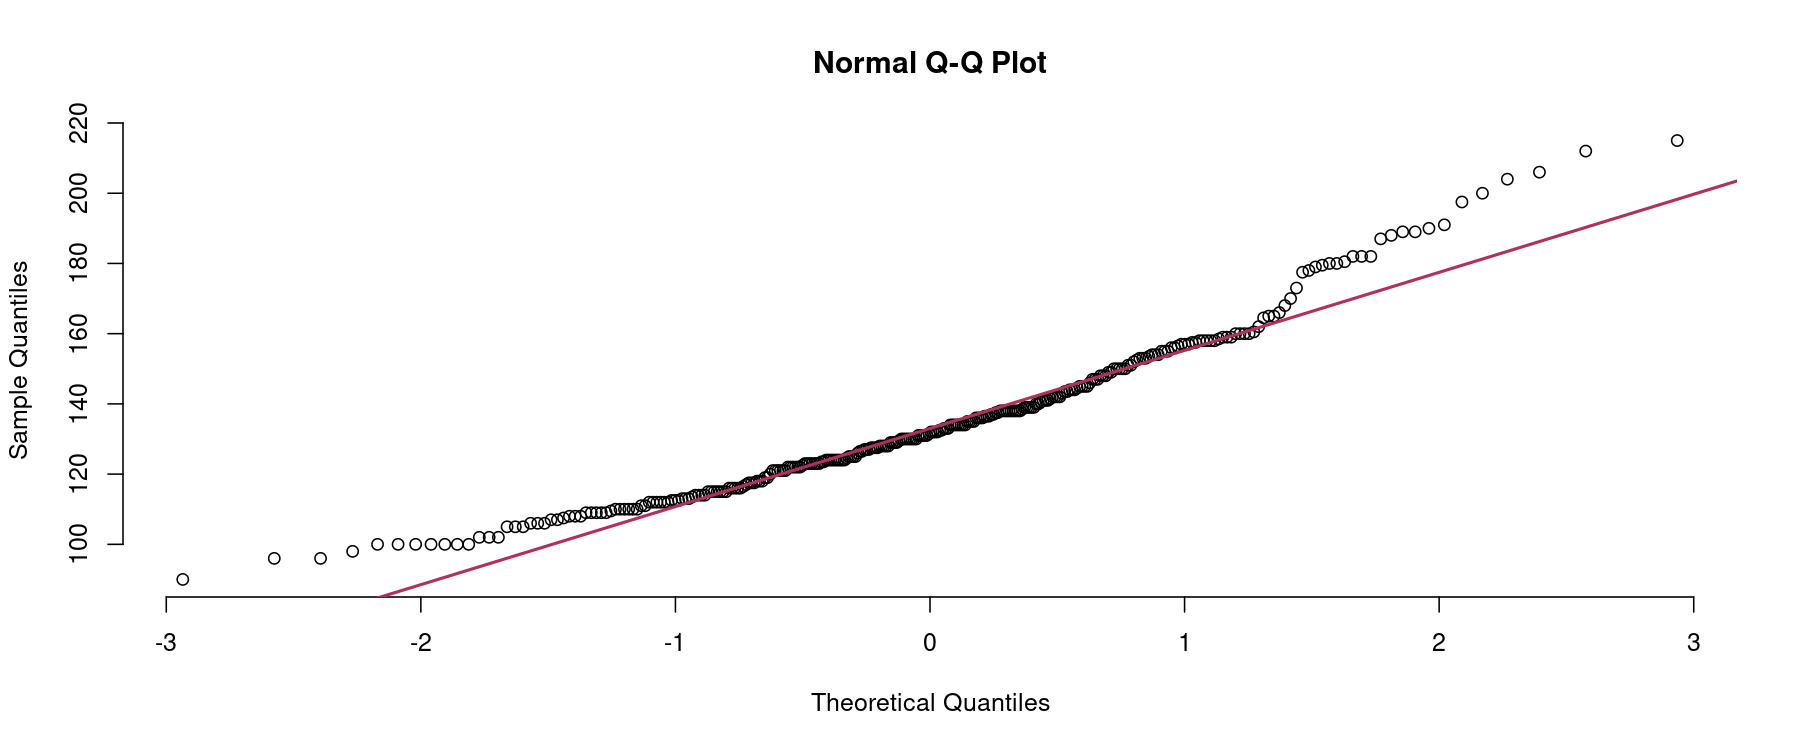

In [22]:
# Normality
qqnorm(df_data$sysBP, pch = 1, frame = FALSE)
qqline(df_data$sysBP, col = "maroon", lwd = 2)

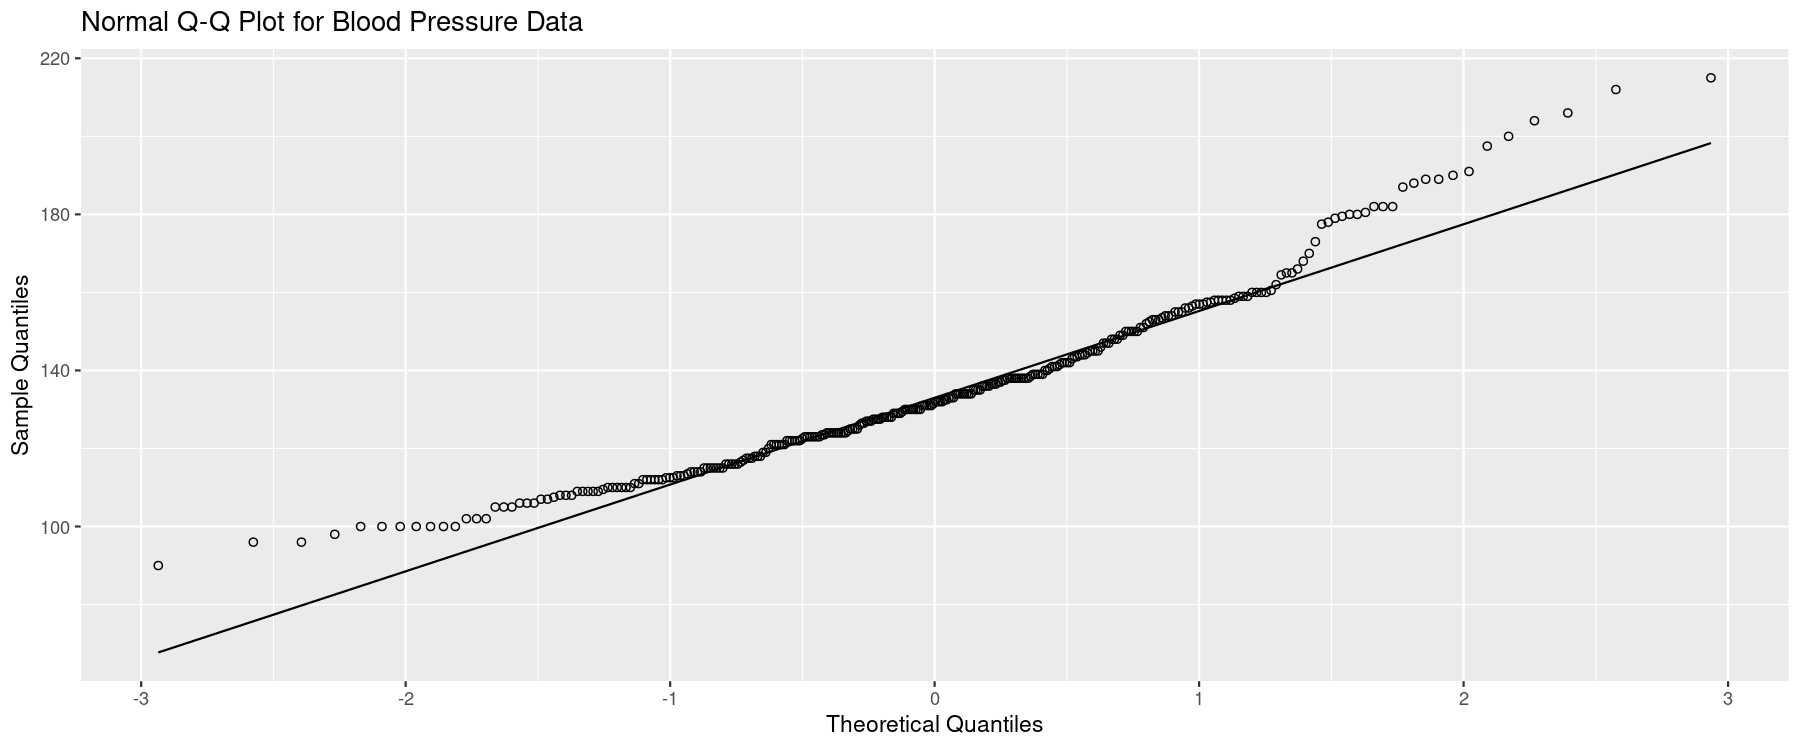

In [23]:
data_qqplot <- 
ggplot(df_data, aes(sample = sysBP)) + 
stat_qq(shape = 1) + stat_qq_line() + 
ggtitle("Normal Q-Q Plot for Blood Pressure Data") + 
xlab("Theoretical Quantiles") +
ylab("Sample Quantiles")

data_qqplot

In [24]:
b1 <- mean(df_data$sysBP - mean(df_data$sysBP))^3 / sqrt(sample_variance(df_data$sysBP))^3

In [25]:
b1

[1] -9.775034e-49

mean(df_data$sysBP - mean(df_data$sysBP))^3

In [26]:
mean((df_data$sysBP - mean(df_data$sysBP))^3) / sqrt(sample_variance(df_data$sysBP))^3

[1] 0.8797915

In [27]:
mean((df_data$sysBP - mean(df_data$sysBP))^4) / sqrt(sample_variance(df_data$sysBP))^4

[1] 3.812361

In [28]:
kurtosis(df_data$sysBP)
skewness(df_data$sysBP)

[1] 0.8123606

[1] 0.8797915

[1] -0.009905921

[1] 2.995056

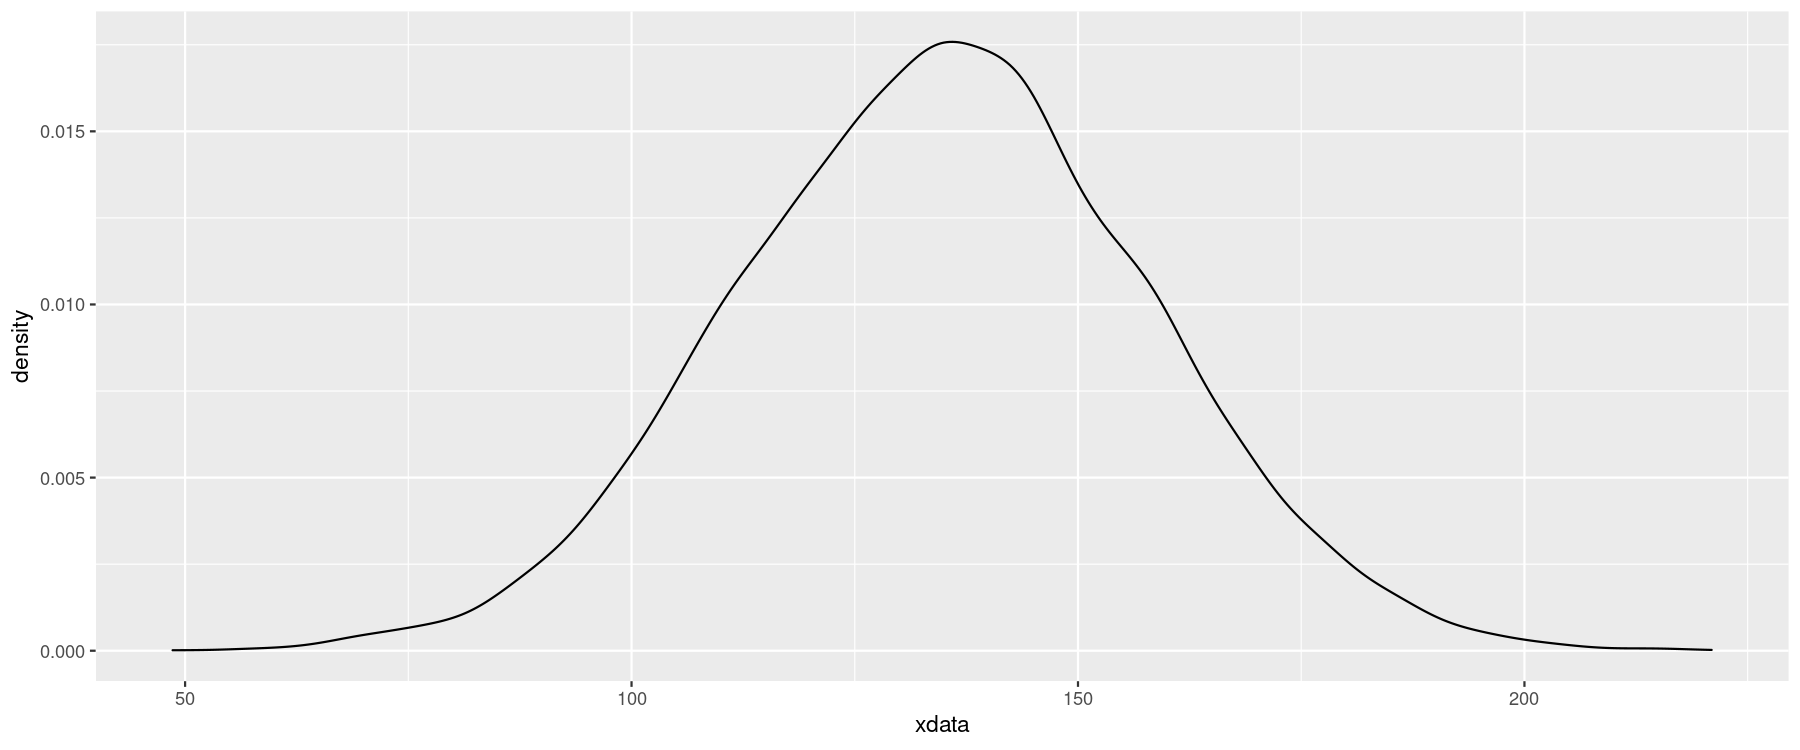

In [29]:
df_test <- data.frame(rnorm(10000, mean(df_data$sysBP), sqrt(sample_variance(df_data$sysBP))))

colnames(df_test) <- "xdata"

ggplot(data = df_test) + geom_density(aes(xdata))

mean((df_test$xdata - mean(df_test$xdata))^3) / sqrt(sample_variance(df_test$xdata))^3

mean((df_test$xdata - mean(df_test$xdata))^4) / sqrt(sample_variance(df_test$xdata))^4

In [30]:
kurt_function <- function(x){
    mean((x - mean(x))^4) / sqrt(sample_variance(x))^4
}

skew_function <- function(x){
    mean((x - mean(x))^3) / sqrt(sample_variance(x))^3
}

skew_function(df_test$xdata)
kurt_function(df_test$xdata)

[1] -0.009905921

[1] 2.995056

In [31]:
skew_function(df_data$sysBP)
kurt_function(df_data$sysBP)

[1] 0.8797915

[1] 3.812361

In [32]:
IQR <- as.numeric(quantile(df_data$sysBP, probs = 0.75)) - 
       as.numeric(quantile(df_data$sysBP, probs = 0.25))

MAD <- median(abs(df_data$sysBP - median(df_data$sysBP)))

In [33]:
sqrt(sample_variance(df_data$sysBP))
IQR/1.35
MAD/0.675

[1] 22.89291

[1] 22.22222

[1] 21.48148

In [96]:
set.seed(1)

alpha <- 0.05

sample_variance <- function(x, sampling = TRUE){
    if (sampling == TRUE){
        sum((x - mean(x))^2) / (length(x) - 1)
    } else if(sampling == FALSE) {
        sum((x - mean(x))^2) / (length(x))
    }
}

test_function <- function (x, y, pooled = FALSE){

    mu_1 <- mean(x)
    var_1 <- sample_variance(x, sampling = TRUE)
    
    mu_2 <- mean(y)
    var_2 <- sample_variance(y, sampling = TRUE)
    
    #Calculate the pooled sample variance
    pooled_sample <- ((length(x) - 1) * var_1 + (length(y) - 1) * var_2) / (length(x) + length(y) - 2)
    
    #calulate the observed t statistic
    if (pooled == TRUE){
        
        cal_sigma <- (sqrt(pooled_sample/length(x) + pooled_sample/length(y)))
        
        ttest <- (mu_1 - mu_2) / cal_sigma
        dof <- length(x) + length(y) - 2 #Determine degrees of freedom
        
        } else {
        
        cal_sigma <- (sqrt(var_1/length(x) + var_2/length(y)))
        
        ttest <- (mu_1 - mu_2) / cal_sigma
        dof <- satterth(var_1, var_2, length(x), length(y))
    }
    
    #Determine whether or not the null hypothesis can be rejected (1 = rejected, 0 = not rejected)
    verdict <- !between(ttest, qt(alpha / 2, dof), qt(1 - alpha / 2, dof))
    
    #Power calculation assuming calculated difference in means is Ha 
    cv_lo <- qnorm(alpha / 2, 0, cal_sigma)
    cv_hi <- qnorm(1 - alpha / 2, 0, cal_sigma)
    
    power1 <- pnorm(cv_lo, (mu_1 - mu_2), cal_sigma)
    power2 <- 1 - pnorm(cv_hi, (mu_1 - mu_2), cal_sigma)
    
    power <- sum(power1, power2)
    
    #Return calculated values
    return(c(mu_1, var_1, mu_2, var_2, ttest, cal_sigma, dof, verdict, power))
}



mu1 <- c(0, 4, 5, 6, 10)
var1 <- c(1, 4, 9)
n1 <- c(10, 30, 70, 100)

mu2 <- 5
var2 <- 1
n2 <- c(10, 30, 70, 100)

sim_test <- function(x_mu, x_var, x_n, y_mu, y_var, y_n, pooled = FALSE){
    
    sim_data_results <- matrix(rep(0, 9), ncol = 9)
    
    for (i in 1:1000){
        
        sim_set1 <- rnorm(x_n, x_mu, sqrt(x_var))
        sim_set2 <- rnorm(y_n, y_mu, sqrt(y_var))
        
        sim_data_results <- rbind(sim_data_results, test_function(sim_set1, sim_set2, pooled))
        
        #print(sim_data_results)
    }
    
    df_sim_data <- data.frame(sim_data_results[2 : nrow(sim_data_results),])
    colnames(df_sim_data) = c("Null Mean", "Null Variance", "Alternate Mean", "Alternate Variance",
                                  "T statistic", "Calculated Variance", "DoF", "Null Reject", "Power")
    return(df_sim_data)
}

# HA: mean = 5, var = 1
test_results_1 <- sim_test(mu1[1], var1[1], n1[1], mu2, var2, n2[1])
test_results_2 <- sim_test(mu1[2], var1[1], n1[1], mu2, var2, n2[1])
test_results_3 <- sim_test(mu1[3], var1[1], n1[1], mu2, var2, n2[1])
test_results_4 <- sim_test(mu1[4], var1[1], n1[1], mu2, var2, n2[1])
test_results_5 <- sim_test(mu1[5], var1[1], n1[1], mu2, var2, n2[1])

test_results_6 <- sim_test(mu1[3], var1[1], n1[1], mu2, var2, n2[1])
test_results_7 <- sim_test(mu1[3], var1[2], n1[1], mu2, var2, n2[1])
test_results_8 <- sim_test(mu1[3], var1[3], n1[1], mu2, var2, n2[1])

test_results_9 <- sim_test(mu1[4], var1[1], n1[1], mu2, var2, n2[1])
test_results_10 <- sim_test(mu1[4], var1[2], n1[1], mu2, var2, n2[1])
test_results_11 <- sim_test(mu1[4], var1[3], n1[1], mu2, var2, n2[1])

test_results_12 <- sim_test(mu1[4], var1[1], n1[1], mu2, var2, n2[1])
test_results_13 <- sim_test(mu1[4], var1[1], n1[2], mu2, var2, n2[1])
test_results_14 <- sim_test(mu1[4], var1[1], n1[3], mu2, var2, n2[1])
test_results_15 <- sim_test(mu1[4], var1[1], n1[4], mu2, var2, n2[1])

test_results_16 <- sim_test(mu1[4], var1[1], n1[1], mu2, var2, n2[2])
test_results_17 <- sim_test(mu1[4], var1[1], n1[2], mu2, var2, n2[2])
test_results_18 <- sim_test(mu1[4], var1[1], n1[3], mu2, var2, n2[2])
test_results_19 <- sim_test(mu1[4], var1[1], n1[4], mu2, var2, n2[2])

test_results_20 <- sim_test(mu1[4], var1[1], n1[1], mu2, var2, n2[3])
test_results_21 <- sim_test(mu1[4], var1[1], n1[2], mu2, var2, n2[3])
test_results_22 <- sim_test(mu1[4], var1[1], n1[3], mu2, var2, n2[3])
test_results_23 <- sim_test(mu1[4], var1[1], n1[4], mu2, var2, n2[3])

test_results_24 <- sim_test(mu1[4], var1[1], n1[1], mu2, var2, n2[4])
test_results_25 <- sim_test(mu1[4], var1[1], n1[2], mu2, var2, n2[4])
test_results_26 <- sim_test(mu1[4], var1[1], n1[3], mu2, var2, n2[4])
test_results_27 <- sim_test(mu1[4], var1[1], n1[4], mu2, var2, n2[4])

test_results_28 <- sim_test(mu1[4], var1[1], n1[2], mu2, var2, n2[4])
test_results_29 <- sim_test(mu1[4], var1[2], n1[2], mu2, var2, n2[4])
test_results_30 <- sim_test(mu1[4], var1[3], n1[2], mu2, var2, n2[4])

test_results_31 <- sim_test(mu1[4], var1[2], n1[3], mu2, var2, n2[4])
test_results_32 <- sim_test(mu1[4], var1[2], n1[4], mu2, var2, n2[4])

test_results_33 <- sim_test(mu1[4], var1[3], n1[3], mu2, var2, n2[4])
test_results_34 <- sim_test(mu1[4], var1[3], n1[4], mu2, var2, n2[4])

In [42]:
set.seed(1)

mu1_list <- list()

for (i in 1:length(mu1)){
   mu1_list[[i]] <- sim_test(mu1[i], var1[1], n1[1], mu2, var2, n2[1])
   print(sum(as.data.frame(mu1_list[i])[,8]))
}

for (i in 1:length(mu1)){
   mu1_list[[i]] <- sim_test(mu1[i], var1[1], n1[1], mu2, var2, n2[1])
   print(sum(as.data.frame(mu1_list[i])[,8]))
}

print(mu2[1])

In [90]:
cv_lo <- qnorm(0.025, 0, sqrt(p_sample_var_1/n_smoker + p_sample_var_1/n_nonsmoker))
cv_hi <- qnorm(0.975, 0, sqrt(p_sample_var_1/n_smoker + p_sample_var_1/n_nonsmoker))

power1 <- pnorm(cv_lo, (mu_smoker - mu_nonsmoker), sqrt(p_sample_var_1/n_smoker + p_sample_var_1/n_nonsmoker))
power2 <- 1 - pnorm(cv_hi, (mu_smoker - mu_nonsmoker), sqrt(p_sample_var_1/n_smoker + p_sample_var_1/n_nonsmoker))

print(sum(power1, power2))

[1] 0.8602283


In [92]:
cv_lo <- qnorm(0.025, 0, (sqrt(var_nonsmoker/n_smoker + var_nonsmoker/n_nonsmoker)))
cv_hi <- qnorm(0.975, 0, (sqrt(var_nonsmoker/n_smoker + var_nonsmoker/n_nonsmoker)))

power1 <- pnorm(cv_lo, (mu_smoker - mu_nonsmoker), (sqrt(var_nonsmoker/n_smoker + var_nonsmoker/n_nonsmoker)))
power2 <- 1 - pnorm(cv_hi, (mu_smoker - mu_nonsmoker), (sqrt(var_nonsmoker/n_smoker + var_nonsmoker/n_nonsmoker)))

print(sum(power1, power2))

[1] 0.8255942


In [86]:
sprintf("Test Results 1: %i", sum(test_results_1[,8]))
sprintf("Test Results 2: %i", sum(test_results_2[,8]))
sprintf("Test Results 3: %i", sum(test_results_3[,8]))
sprintf("Test Results 4: %i", sum(test_results_4[,8]))
sprintf("Test Results 5: %i", sum(test_results_5[,8]))
sprintf("Test Results 6: %i", sum(test_results_6[,8]))
sprintf("Test Results 7: %i", sum(test_results_7[,8]))
sprintf("Test Results 8: %i", sum(test_results_8[,8]))
sprintf("Test Results 9: %i", sum(test_results_9[,8]))
sprintf("Test Results 10: %i", sum(test_results_10[,8]))
sprintf("Test Results 11: %i", sum(test_results_11[,8]))
sprintf("Test Results 12: %i", sum(test_results_12[,8]))
sprintf("Test Results 13: %i", sum(test_results_13[,8]))
sprintf("Test Results 14: %i", sum(test_results_14[,8]))
sprintf("Test Results 15: %i", sum(test_results_15[,8]))
sprintf("Test Results 16: %i", sum(test_results_16[,8]))
sprintf("Test Results 17: %i", sum(test_results_17[,8]))
sprintf("Test Results 18: %i", sum(test_results_18[,8]))
sprintf("Test Results 19: %i", sum(test_results_19[,8]))
sprintf("Test Results 20: %i", sum(test_results_20[,8]))
sprintf("Test Results 21: %i", sum(test_results_21[,8]))
sprintf("Test Results 22: %i", sum(test_results_22[,8]))
sprintf("Test Results 23: %i", sum(test_results_23[,8]))
sprintf("Test Results 24: %i", sum(test_results_24[,8]))
sprintf("Test Results 25: %i", sum(test_results_25[,8]))
sprintf("Test Results 26: %i", sum(test_results_26[,8]))
sprintf("Test Results 27: %i", sum(test_results_27[,8]))
sprintf("Test Results 28: %i", sum(test_results_28[,8]))
sprintf("Test Results 29: %i", sum(test_results_29[,8]))
sprintf("Test Results 30: %i", sum(test_results_30[,8]))
sprintf("Test Results 31: %i", sum(test_results_31[,8]))
sprintf("Test Results 32: %i", sum(test_results_32[,8]))
sprintf("Test Results 33: %i", sum(test_results_33[,8]))
sprintf("Test Results 34: %i", sum(test_results_34[,8]))

[1] "Test Results 1: 1000"

[1] "Test Results 2: 566"

[1] "Test Results 3: 47"

[1] "Test Results 4: 559"

[1] "Test Results 5: 1000"

[1] "Test Results 6: 37"

[1] "Test Results 7: 51"

[1] "Test Results 8: 48"

[1] "Test Results 9: 561"

[1] "Test Results 10: 242"

[1] "Test Results 11: 162"

[1] "Test Results 12: 560"

[1] "Test Results 13: 723"

[1] "Test Results 14: 747"

[1] "Test Results 15: 781"

[1] "Test Results 16: 707"

[1] "Test Results 17: 971"

[1] "Test Results 18: 992"

[1] "Test Results 19: 997"

[1] "Test Results 20: 785"

[1] "Test Results 21: 996"

[1] "Test Results 22: 1000"

[1] "Test Results 23: 1000"

[1] "Test Results 24: 755"

[1] "Test Results 25: 997"

[1] "Test Results 26: 1000"

[1] "Test Results 27: 1000"

[1] "Test Results 28: 999"

[1] "Test Results 29: 742"

[1] "Test Results 30: 434"

[1] "Test Results 31: 972"

[1] "Test Results 32: 995"

[1] "Test Results 33: 766"

[1] "Test Results 34: 882"

In [94]:
test_results_16

Null Mean,Null Variance,Alternate Mean,Alternate Variance,T statistic,Calculated Variance,DoF,Null Reject,Power
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5.939640,1.4049729,4.922650,1.1885632,2.396297,0.4244008,14,1,0.6687089
6.479334,0.3812937,4.799082,0.9085878,6.423869,0.2615638,24,1,0.9999960
6.367548,1.5570845,5.201255,1.2257420,2.630588,0.4433582,14,1,0.7487722
5.540657,1.0890352,4.811495,1.2104273,1.887407,0.3863303,16,0,0.4711389
6.215443,0.8801056,5.090845,1.0534083,3.204984,0.3508905,16,1,0.8934379
5.840335,0.6622708,4.963037,1.0534883,2.755810,0.3183447,19,1,0.7869403
5.937312,0.8011844,5.134312,0.8559095,2.436144,0.3296191,15,1,0.6830325
5.691419,0.9534827,5.208955,0.6487547,1.410656,0.3420138,13,0,0.2917722
6.696885,0.4403113,4.910236,1.0757440,6.321136,0.2826469,24,1,0.9999935


In [45]:
sim_data_results <- matrix(rep(0, 8), ncol = 8)
sim_data_results <- rbind(sim_data_results, test_function(rnorm(100, 2, 5), rnorm(100, 4, 5), pooled = FALSE))
print(sim_data_results)

         [,1]     [,2]     [,3]     [,4]      [,5]      [,6] [,7] [,8]
[1,] 0.000000  0.00000 0.000000  0.00000  0.000000 0.0000000    0    0
[2,] 2.797863 23.85762 4.340263 18.64078 -2.365979 0.6519079  195    1



Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor




       H0              HA       
 Min.   :5.121   Min.   :3.728  
 1st Qu.:6.574   1st Qu.:4.978  
 Median :7.067   Median :5.919  
 Mean   :7.082   Mean   :5.924  
 3rd Qu.:7.595   3rd Qu.:6.692  
 Max.   :9.310   Max.   :8.582  

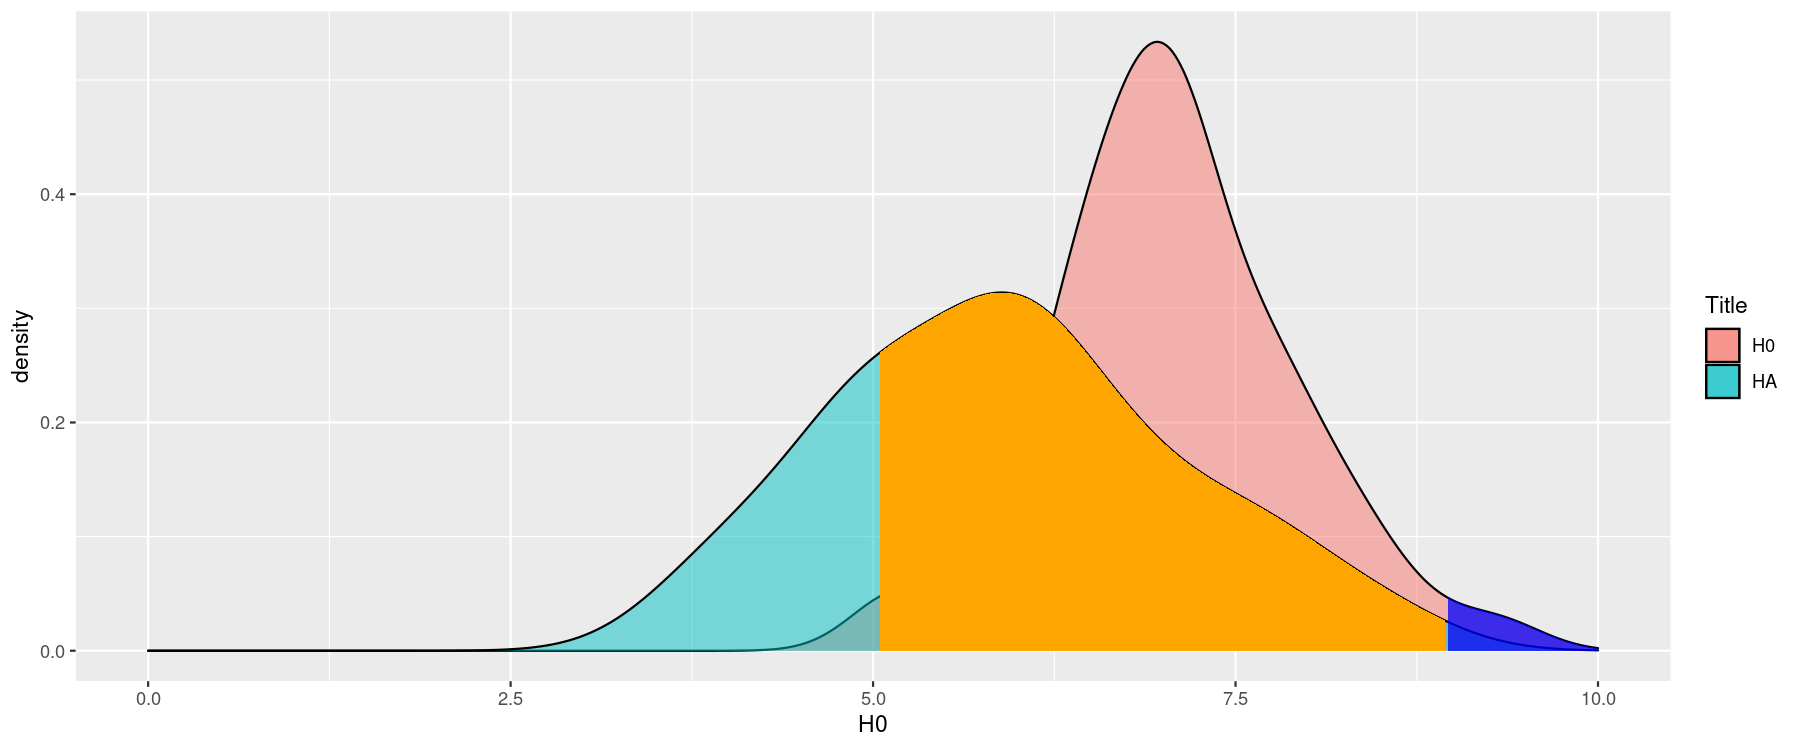

In [46]:
library(tidyverse)
library(scales)

set.seed(100)

sim1 <- rnorm(50, 7, sqrt(1))
sim2 <- rnorm(50, 6, sqrt(1))

alpha1 <- qnorm(0.025, 7, sqrt(1)) 
alpha2 <- qnorm(0.975, 7, sqrt(1))

df_set <- tibble("H0" = sim1, "HA" = sim2)

df_set %>% summary()

ggplot(data = df_set) + geom_density(aes(H0, fill = "blue"), alpha = 0.5) + 
                        geom_density(aes(HA, fill = "red"), alpha = 0.5) + 
                        geom_area(
                            aes(x = stage(H0, after_scale = oob_censor(x, alpha2
                                                                      )
                                         )
                               ),
                            stat = "density", fill = "blue", alpha = 0.75
                        ) + 
                        geom_area(
                            aes(x = stage(HA, after_scale = oob_censor(x, c(alpha1, alpha2)
                                                                     )
                                         )
                               ),
                            stat = "density", fill = "orange"
                        ) +
                        xlim(0, 10) + labs(fill = "Title") + scale_fill_hue(labels = c("H0", "HA"))

In [47]:
alpha

[1] 0.05

       H0               HA       
 Min.   : 3.679   Min.   :3.119  
 1st Qu.: 6.394   1st Qu.:5.319  
 Median : 6.940   Median :6.108  
 Mean   : 6.962   Mean   :6.071  
 3rd Qu.: 7.633   3rd Qu.:6.780  
 Max.   :10.304   Max.   :9.092  

Warning message:
“Removed 1 rows containing non-finite values (stat_density).”
Warning message:
“Removed 1 rows containing non-finite values (stat_density).”
Warning message:
“Removed 1 rows containing non-finite values (stat_density).”


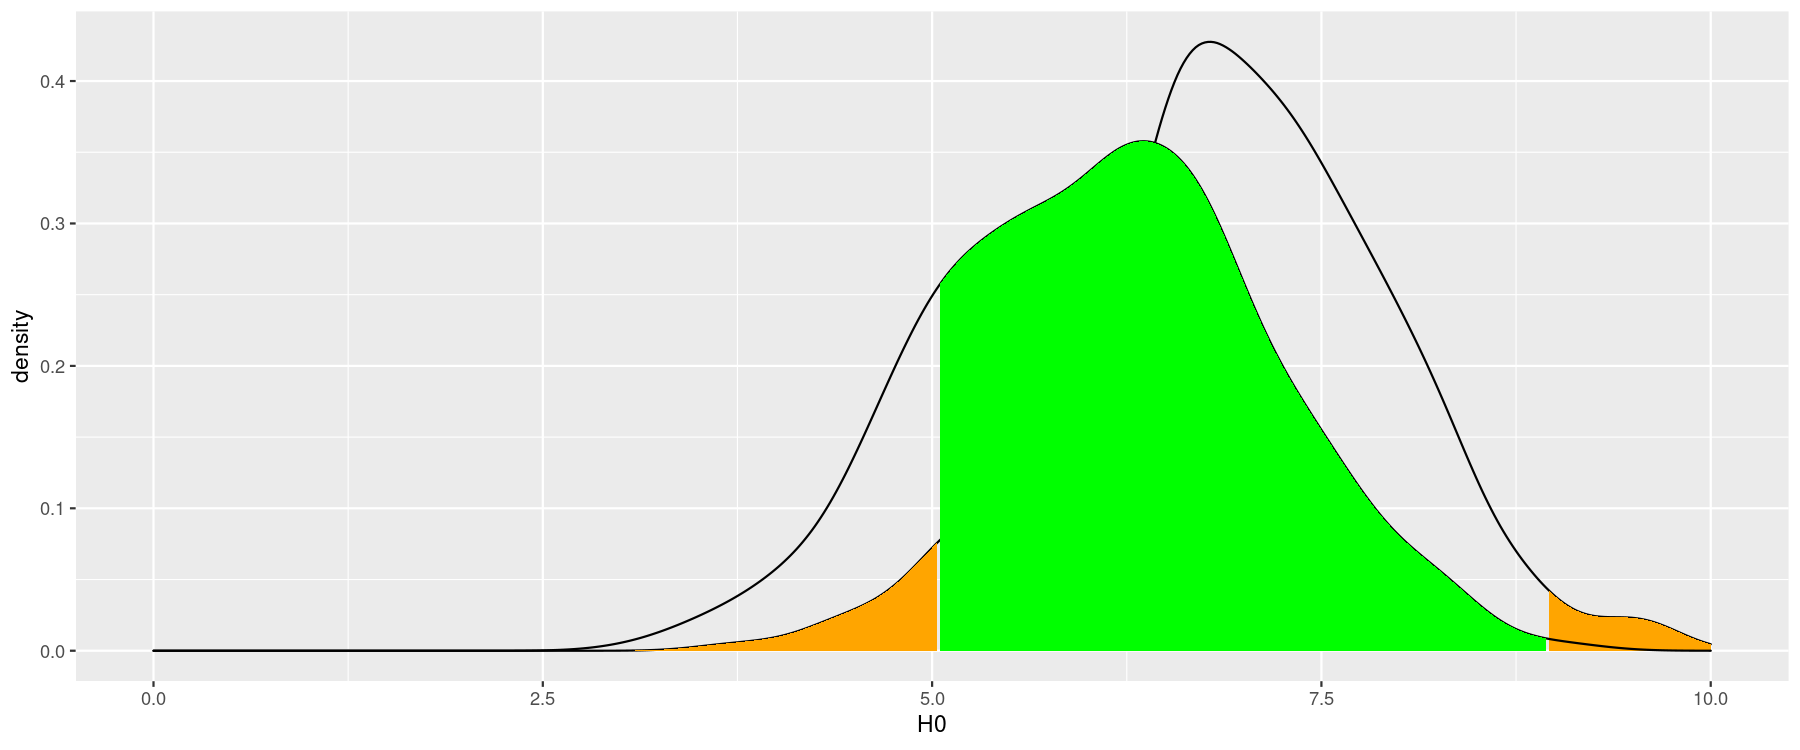

In [48]:
library(tidyverse)
library(scales)

set.seed(100)

sim1 <- rnorm(500, 7, sqrt(1))
sim2 <- rnorm(500, 6, sqrt(1))

alpha1 <- qnorm(0.025, 7, sqrt(1)) 
alpha2 <- qnorm(0.975, 7, sqrt(1))

df_set <- tibble("H0" = sim1, "HA" = sim2)

df_set %>% summary()

ggplot(data = df_set) + geom_density(aes(H0), alpha = 0.5) + 
                        geom_area(
                            aes(x = stage(H0, after_scale = oob_censor(x, c(0, alpha1)
                                                                      )
                                         )
                               ),
                            stat = "density", fill = "orange"
                                 ) +
                        geom_area(
                            aes(x = stage(H0, after_scale = oob_censor(x, c(alpha2, Inf)
                                                                      )
                                         )
                               ),
                            stat = "density", fill = "orange"
                                 ) +
                        geom_density(aes(HA), alpha = 0.5) + 
                        geom_area(
                            aes(x = stage(HA, after_scale = oob_censor(x, c(alpha1, alpha2)
                                                                      )
                                         )
                               ),
                            stat = "density", fill = "green"
                                 ) +
                        xlim(0,10) + guides(fill = guide_legend(title = "Title"))


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Warning message:
“Removed 118 rows containing non-finite values (stat_density).”
Warning message:
“Removed 118 rows containing non-finite values (stat_density).”
Warning message:
“Removed 7 rows containing non-finite values (stat_density).”
Warning message:
“Removed 7 rows containing non-finite values (stat_density).”
Warning message:
“Removed 1 rows containing non-finite values (stat_density).”
Warning message:
“Removed 1 rows containing non-finite values (stat_density).”
Warning message:
“Removed 5 rows containing non-finite values (stat_density).”
Warning message:
“Removed 5 rows containing non-finite values (stat_density).”


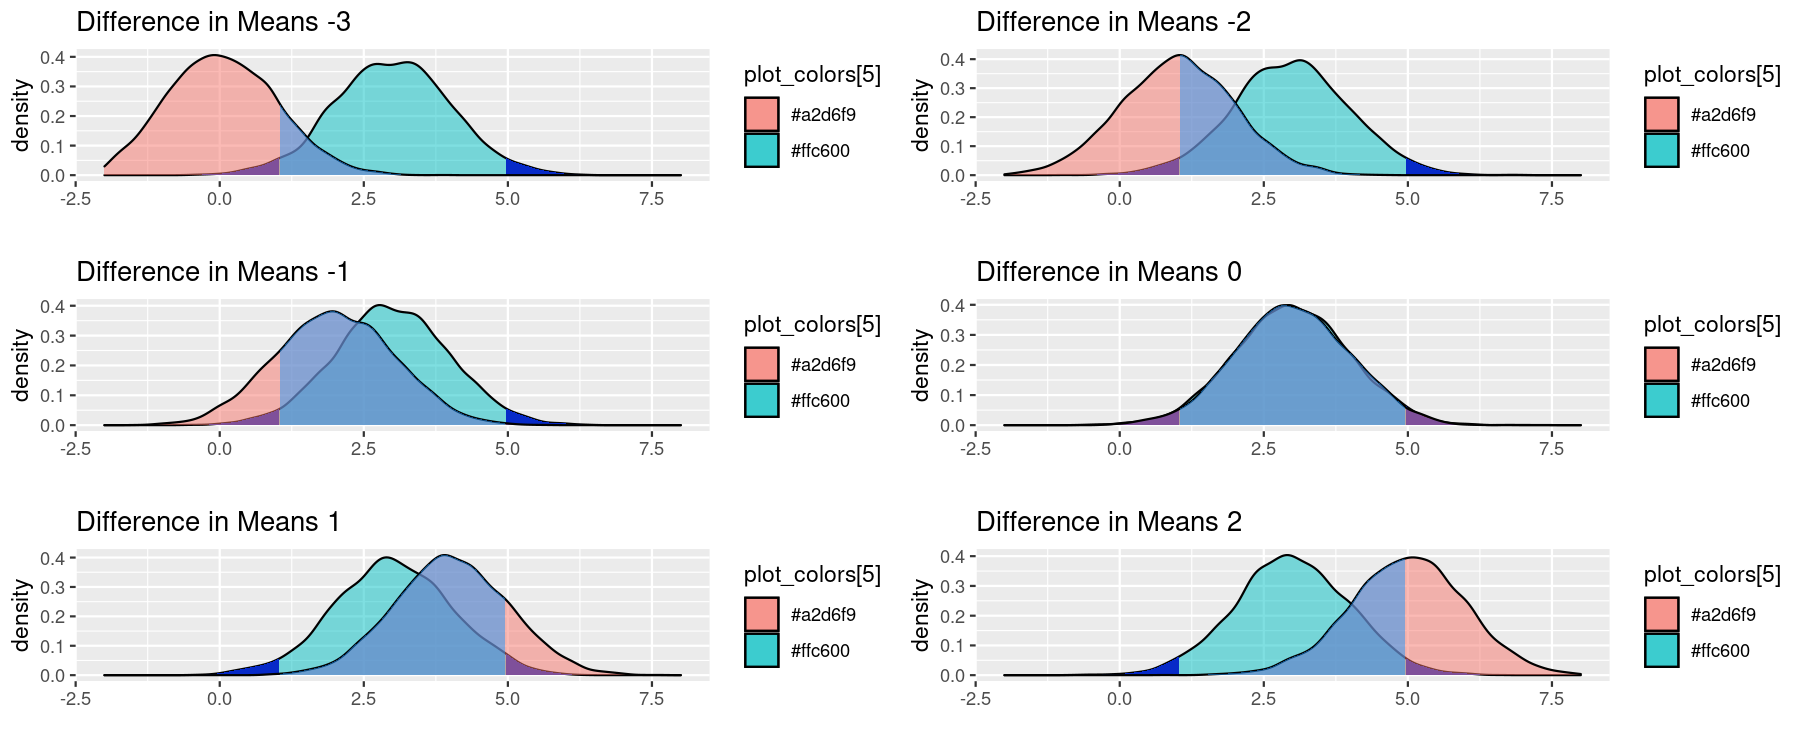

In [49]:
options(warn=0)

library(gridExtra)

options(repr.plot.width = 12, repr.plot.height = 5, repr.plot.res = 150)
set.seed(100)

null_mean <- 3
alt_means <- c(0, 1, 2, 3, 4, 5)
plot_list <- list()

plot_colors <- c("#072ac8","#1e96fc","#a2d6f9","#fcf300","#ffc600")

for(i in 1:6){
    
    sim1 <- rnorm(5000, null_mean, sqrt(1))
    sim2 <- rnorm(5000, alt_means[i], sqrt(1))

    alpha1 <- qnorm(0.025, null_mean, sqrt(1)) 
    alpha2 <- qnorm(0.975, null_mean, sqrt(1))

    df_set <- tibble("H0" = sim1, "HA" = sim2)
    
    title_string <- sprintf("Difference in Means %i", (alt_means[i] - null_mean))

    plot_list[[i]]  <-
    ggplot(data = df_set) + geom_density(aes(H0, fill = plot_colors[5]), alpha = 0.5) + 
                            geom_area(
                                aes(x = stage(H0, after_scale = oob_censor(x, c(-Inf, alpha1)
                                                                          )
                                             )
                                   ),
                                stat = "density", fill = plot_colors[1]
                                 ) +
                            geom_area(
                                aes(x = stage(H0, after_scale = oob_censor(x, c(alpha2, Inf)
                                                                          )
                                             )
                                   ),
                                stat = "density", fill = plot_colors[1]
                                     ) +
                            geom_density(aes(HA, fill = plot_colors[3]), alpha = 0.5) + 
                            geom_area(
                                aes(x = stage(HA, after_scale = oob_censor(x, c(alpha1, alpha2)
                                                                          )
                                             )
                                   ),
                                stat = "density", fill = plot_colors[2], alpha = 0.5
                                     ) +
                            xlim(-2, 8) + xlab("") + ggtitle(title_string)
    
                                }

do.call(grid.arrange, plot_list)

In [50]:
set.seed(1)

sum1 <- 0
sum2 <- 0

dofs <- list()

for(i in 1:1000){

x1 <- rnorm(70, 6, 2)
x2 <- rnorm(70, 5, 2)

f_pooled_variance(x1, x2)
sample_variance(x1)
sample_variance(x2)

dofp <- length(x1) + length(x2) - 2

ta1 <-  qt(alpha / 2, length(x1) + length(x2) - 2)
ta2 <- qt(1 - alpha / 2, length(x1) + length(x2) - 2)

t_stat1 <- (mean(x1) - mean(x2)) / (sqrt(f_pooled_variance(x1, x2)/length(x1) + f_pooled_variance(x1, x2)/length(x2)))

    verd1 <- !between(t_stat1, ta1, ta2)

    dofd <- satterth(sample_variance(x1), sample_variance(x2), length(x1), length(x2))

    tb1 <- qt(alpha / 2, satterth(sample_variance(x1), sample_variance(x2), length(x1), length(x2)))
    tb2 <- qt(1 - alpha / 2, satterth(sample_variance(x1), sample_variance(x2), length(x1), length(x2)))

    t_stat2 <- (mean(x1) - mean(x2)) / (sqrt(sample_variance(x1)/length(x1) + sample_variance(x2)/length(x2)))

    verd2 <- !between(t_stat2, tb1, tb2)
    
    sum1 <- sum1 + verd1
    sum2 <- sum2 + verd2
    
    dofs[[i]] <- c(dofp, dofd)
    
    }


print(c(sum1, sum2))
#print(c(ta1, t_stat1, ta2))
#print(c(tb1, t_stat2, tb2))
#print(c(verd1, verd2))

[1] 844 844


In [51]:
mu_smoker - mu_nonsmoker

[1] -9.157778

In [52]:
set.seed(2)
sum(sim_test(5.5, 3, 500, 5, 3, 500)[,8])

[1] 995

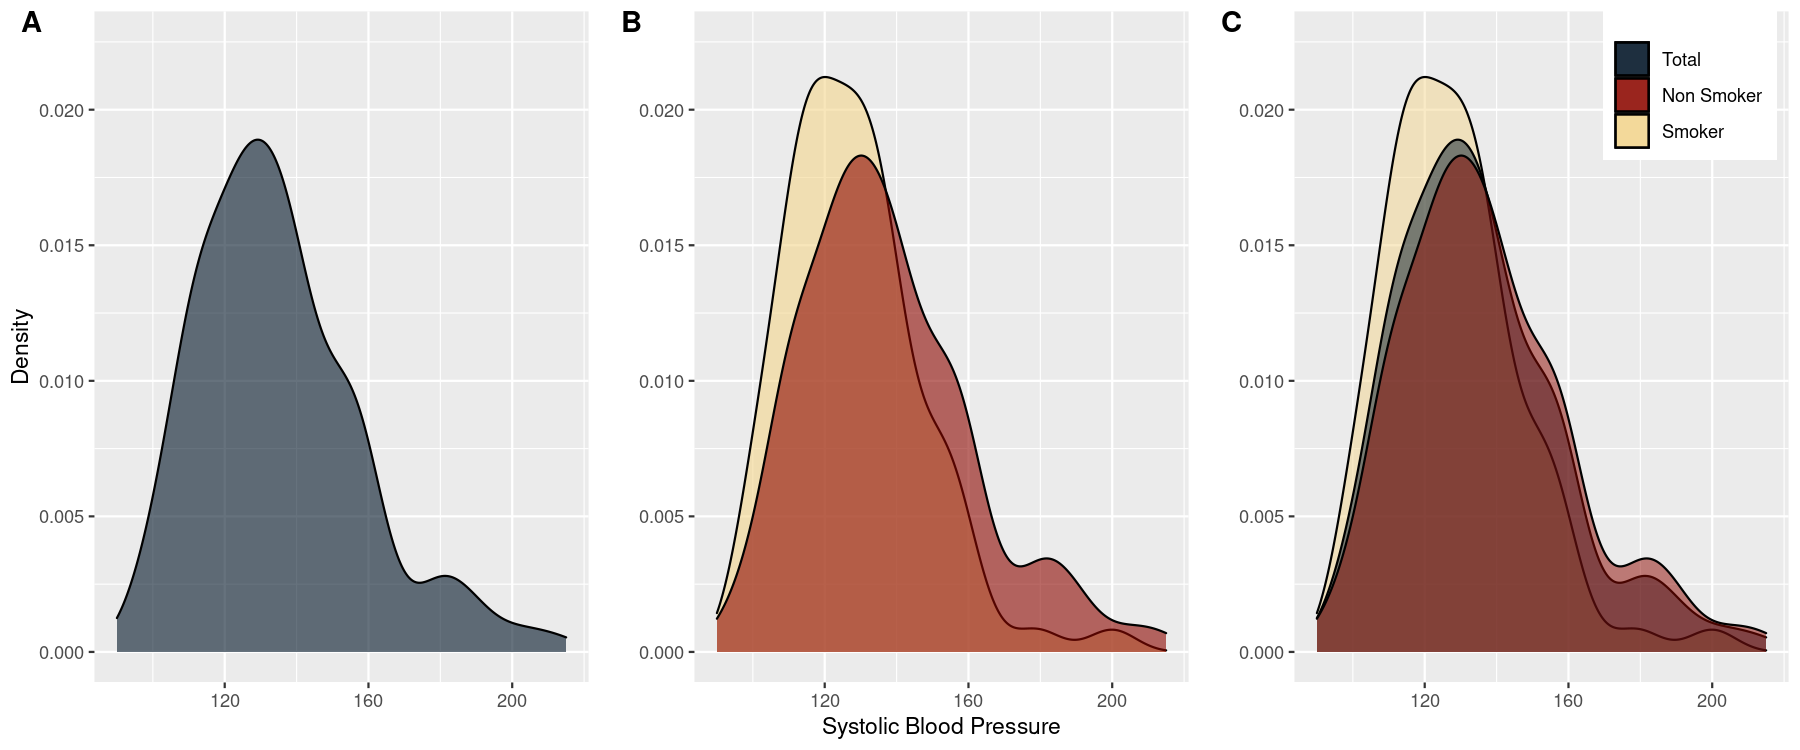

In [53]:
plot_colors <- c("#001427","#708d81","#f4d58d","#bf0603","#8d0801")
y_limits <- c(0, 0.0225)

total_data <- ggplot(df_data) + geom_density(aes(sysBP), 
                                             fill = plot_colors[1],
                                             alpha = 0.6) +
                       ylim(y_limits) + ylab("Density") + xlab("")

sep_data <- ggplot() + geom_density(data = df_smoker, aes(sysBP), 
                                    fill = plot_colors[3], alpha = 0.6) + 
                       geom_density(data = df_nonsmoker, aes(sysBP), 
                                    fill = plot_colors[5], alpha = 0.6) +
                       ylim(y_limits) + ylab("") + xlab("Systolic Blood Pressure")

plot_3 <- ggplot() + geom_density(data = df_smoker, aes(sysBP, fill = plot_colors[3]), alpha = 0.5) + 
                     geom_density(data = df_data, aes(sysBP, fill = plot_colors[1]), alpha = 0.5) +
                     geom_density(data = df_nonsmoker, aes(sysBP, fill = plot_colors[5]), alpha = 0.5) +
                     ylim(y_limits) + ylab("") + xlab("") + 
                     scale_fill_manual("",
                                       values = plot_colors[c(1, 5, 3)], 
                                       labels = c("Total", "Non Smoker", "Smoker")) +
                     theme(legend.position = c(0.8, 0.9))

plot_grid(total_data, sep_data, plot_3, 
          hjust = -1,nrow = 1, ncol = 3, labels = c("A", "B", "C"))

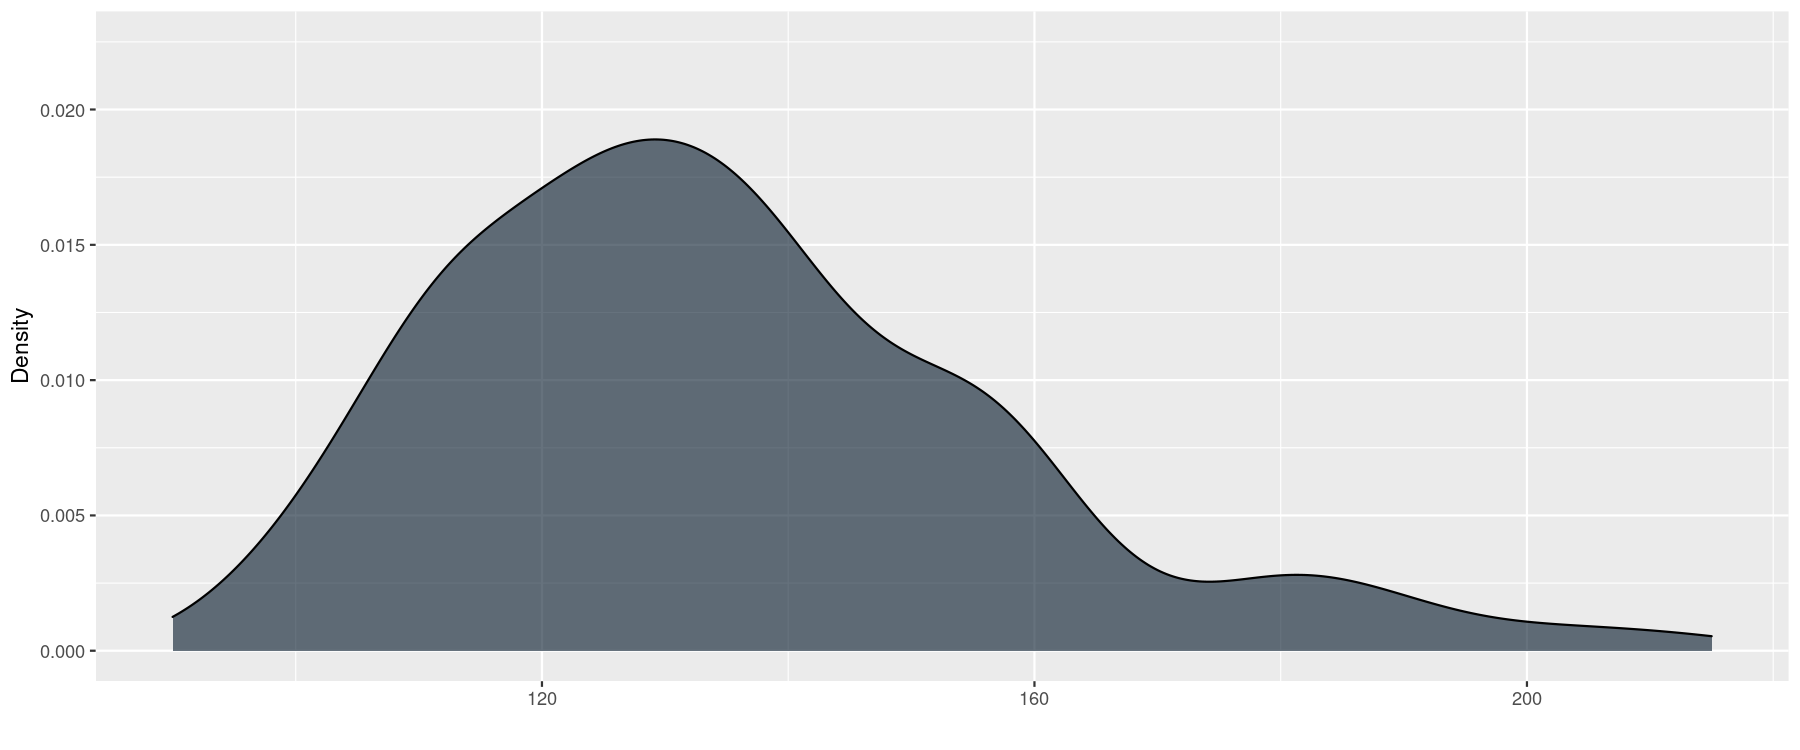

In [54]:
total_data

In [97]:
set.seed(1)

mu1 <- c(0, 4, 5, 6, 10)
var1 <- c(1, 4, 9)
n1 <- c(10, 30, 70)

mu2 <- 5
var2 <- 1
n2 <- c(10, 30, 70)


df_combo <- expand.grid(mu1, var1, n1, mu2, var2, n2)
df_combo2 <- tibble(cbind(1:nrow(df_combo), df_combo, matrix(rep(0, 2 * nrow(df_combo)), ncol = 2)))
colnames(df_combo2) <- c("Test_Case", "mu1", "var1", "n1", "mu2", "var2", "n2", "Test_Results_up", "Test_Results_po")

test_results <- list() # pooled
test_results2 <- list() # not pooled

for (i in 1:nrow(df_combo)){
    test_results[[i]] <- do.call(sim_test, as.list(as.numeric(df_combo[i,])))
    test_results2[[i]] <- do.call(sim_test, as.list(as.numeric(c(df_combo[i,], pooled = TRUE))))
    df_combo2[i, 8] <- sum(as.data.frame(test_results[i])[,8])
    df_combo2[i, 9] <- sum(as.data.frame(test_results2[i])[,8])    
    }



#for (i in 1:nrow(df_combo)){
#    test_results2[[i]] <- do.call(sim_test, as.list(as.numeric(c(df_combo[i,], pooled = TRUE))))
#    df_combo2[i, 9] <- sum(as.data.frame(test_results2[i])[,8])
#    }

df_combo2 <- df_combo2 %>% mutate(diff = mu1 - mu2)

df_combo2 %>% head()

Test_Case,mu1,var1,n1,mu2,var2,n2,Test_Results_up,Test_Results_po,diff
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,1,10,5,1,10,1000,1000,-5
2,4,1,10,5,1,10,578,562,-1
3,5,1,10,5,1,10,54,39,0
4,6,1,10,5,1,10,527,546,1
5,10,1,10,5,1,10,1000,1000,5
6,0,4,10,5,1,10,1000,1000,-5


In [99]:
df_combo2 %>% head()

Test_Case,mu1,var1,n1,mu2,var2,n2,Test_Results_up,Test_Results_po,diff
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,1,10,5,1,10,1000,1000,-5
2,4,1,10,5,1,10,578,562,-1
3,5,1,10,5,1,10,54,39,0
4,6,1,10,5,1,10,527,546,1
5,10,1,10,5,1,10,1000,1000,5
6,0,4,10,5,1,10,1000,1000,-5


In [100]:
df_combo2  %>% mutate(diff = mu1 - mu2) %>% filter(Test_Results_up <= 950, diff !=0 ) %>% select(diff) %>% unique()

diff
<dbl>
-1
1


In [101]:
as.numeric(df_combo2[2,8] + df_combo2[5,8])

[1] 1578

In [113]:
cbind(unname(summary(test_results[[9]]["Power"])), 
      unname(summary(test_results[[129]]["Power"])))

Min. :0.0500,Min. :0.07074
1st Qu.:0.1169,1st Qu.:0.86108
Median :0.2979,Median :0.96526
Mean :0.3793,Mean :0.89540
3rd Qu.:0.6115,3rd Qu.:0.99472
Max. :1.0000,Max. :1.00000


In [191]:
pow_tab_3 <- test_results[[3]] %>% pull(Power) %>% summary() %>% unname() %>% matrix(ncol = 1)
pow_tab_4 <- test_results[[4]] %>% pull(Power) %>% summary() %>% unname() %>% matrix(ncol = 1)
pow_tab_5 <- test_results[[5]] %>% pull(Power) %>% summary() %>% unname() %>% matrix(ncol = 1)

d <- cbind(pow_tab_3, pow_tab_4, pow_tab_5)
                                               
colnames(d) = c("Test Case #3","Test Case #4", "Test Case #5")
rownames(d) = c("Min", "1st Quantile", "Median", "Mean", "3rd Quantile", "Max")

knitr::kable(d, ESCAPE = FALSE)



|             | Test Case #3| Test Case #4| Test Case #5|
|:------------|------------:|------------:|------------:|
|Min          |    0.0500011|    0.0500784|    0.9999048|
|1st Quantile |    0.0612452|    0.3230909|    1.0000000|
|Median       |    0.1034285|    0.5907844|    1.0000000|
|Mean         |    0.1789803|    0.5725561|    0.9999999|
|3rd Quantile |    0.2254709|    0.8478397|    1.0000000|
|Max          |    0.9932574|    1.0000000|    1.0000000|

In [190]:
pow_tab_3 <- test_results2[[3]] %>% pull(Power) %>% summary() %>% unname() %>% matrix(ncol = 1)
pow_tab_4 <- test_results2[[4]] %>% pull(Power) %>% summary() %>% unname() %>% matrix(ncol = 1)
pow_tab_5 <- test_results2[[5]] %>% pull(Power) %>% summary() %>% unname() %>% matrix(ncol = 1)

d <- cbind(pow_tab_3, pow_tab_4, pow_tab_5)
                                               
colnames(d) = c("Test Case #3","Test Case #4", "Test Case #5")
rownames(d) = c("Min", "1st Quantile", "Median", "Mean", "3rd Quantile", "Max")

knitr::kable(d, ESCAPE = FALSE)



|             | Test Case #3| Test Case #4| Test Case #5|
|:------------|------------:|------------:|------------:|
|Min          |    0.0500008|    0.0500029|    0.9999895|
|1st Quantile |    0.0608677|    0.3537665|    1.0000000|
|Median       |    0.0976138|    0.6118020|    1.0000000|
|Mean         |    0.1622605|    0.5874067|    1.0000000|
|3rd Quantile |    0.1935517|    0.8427393|    1.0000000|
|Max          |    0.9732187|    1.0000000|    1.0000000|

In [151]:
df_data %>% filter(currentSmoker == 1) %>% pull(sysBP) %>% sample_variance() %>% sqrt()
df_data %>% filter(currentSmoker == 0) %>% pull(sysBP) %>% sample_variance() %>% sqrt()
df_data %>% pull(sysBP) %>% sample_variance() %>% sqrt()

[1] 18.7673

[1] 23.70959

[1] 22.89291

In [184]:
df_combo

Var1,Var2,Var3,Var4,Var5,Var6
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,1,10,5,1,10
4,1,10,5,1,10
5,1,10,5,1,10
6,1,10,5,1,10
10,1,10,5,1,10
0,4,10,5,1,10
4,4,10,5,1,10
5,4,10,5,1,10
6,4,10,5,1,10


In [187]:
expand.grid(c(1, 2), c(3,4,5))

Var1,Var2
<dbl>,<dbl>
1,3
2,3
1,4
2,4
1,5
2,5


In [189]:
test_results[[50]]

Null Mean,Null Variance,Alternate Mean,Alternate Variance,T statistic,Calculated Variance,DoF,Null Reject,Power
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
9.764645,0.5511805,5.174067,0.5908960,16.783180,0.2735225,15,1,1
9.777783,1.2465081,4.952330,0.9565528,12.196385,0.3956462,13,1,1
9.805767,0.6836815,5.029049,0.8328170,15.406466,0.3100463,16,1,1
9.928718,1.4589945,5.064762,1.5106904,10.979393,0.4430077,15,1,1
10.119506,0.7076942,4.728829,0.7113918,17.537499,0.3073800,15,1,1
10.661917,0.8530752,4.946085,0.6708967,17.419296,0.3281322,14,1,1
10.416551,1.1471861,4.982812,0.5843628,14.832923,0.3663296,12,1,1
10.240301,1.1513138,4.716890,1.1048305,14.169158,0.3898193,15,1,1
9.853141,0.5950632,4.702735,0.9072243,17.192189,0.2995783,18,1,1


Warning message:
“Removed 118 rows containing non-finite values (stat_density).”
Warning message:
“Removed 118 rows containing non-finite values (stat_density).”
Warning message:
“Removed 6 rows containing non-finite values (stat_density).”
Warning message:
“Removed 6 rows containing non-finite values (stat_density).”


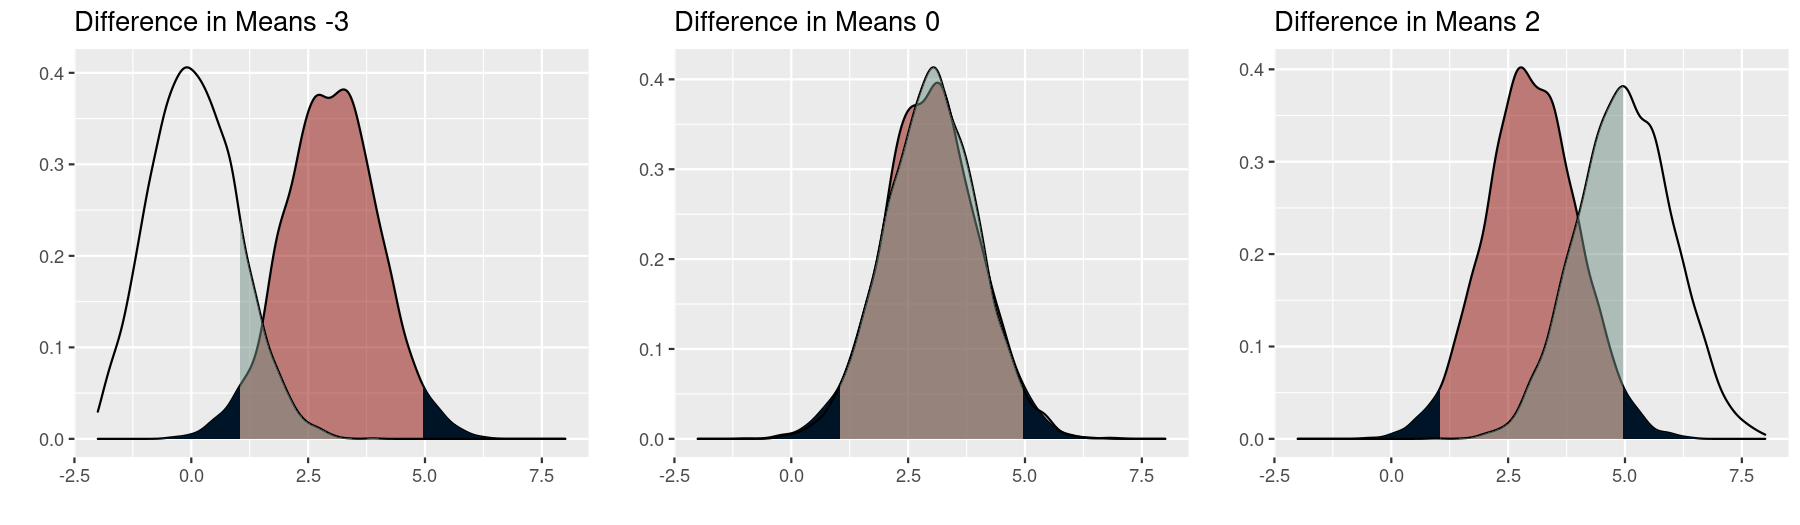

In [206]:
library(cowplot)
options(repr.plot.width = 12, repr.plot.height = 3.5, repr.plot.res = 150)
set.seed(100)

null_mean <- 3
alt_means <- c(0, 3, 5)
plot_list <- list()

#plot_colors <- c("#072ac8","#1e96fc","#a2d6f9","#fcf300","#ffc600")

for(i in 1:length(alt_means)){
    
    sim1 <- rnorm(5000, null_mean, sqrt(1))
    sim2 <- rnorm(5000, alt_means[i], sqrt(1))

    alpha1 <- qnorm(0.025, null_mean, sqrt(1)) 
    alpha2 <- qnorm(0.975, null_mean, sqrt(1))

    df_set <- tibble("H0" = sim1, "HA" = sim2)
    
    title_string <- sprintf("Difference in Means %i", (alt_means[i] - null_mean))

    plot_list[[i]]  <-
    ggplot(data = df_set) + geom_density(aes(H0), alpha = 0.5, fill = plot_colors[5]) + 
                            geom_area(
                                aes(x = stage(H0, after_scale = oob_censor(x, c(-Inf, alpha1)
                                                                          )
                                             )
                                   ),
                                stat = "density", fill = plot_colors[1]
                                 ) +
                            geom_area(
                                aes(x = stage(H0, after_scale = oob_censor(x, c(alpha2, Inf)
                                                                          )
                                             )
                                   ),
                                stat = "density", fill = plot_colors[1]
                                     ) +
                            geom_density(aes(HA), alpha = 0.5) + 
                            geom_area(
                                aes(x = stage(HA, after_scale = oob_censor(x, c(alpha1, alpha2)
                                                                          )
                                             )
                                   ),
                                stat = "density", fill = plot_colors[2], alpha = 0.5
                                     ) +
                            xlim(-2, 8) + xlab("") + ylab("") + ggtitle(title_string)
    
                                }

do.call(plot_grid, c(plot_list, ncol = 3))

In [219]:
np_sample_var_2 <- (var_nonsmoker/n_smoker + var_nonsmoker/n_nonsmoker)
p_sample_var_w <- sqrt(p_sample_var_1/n_smoker + p_sample_var_1/n_nonsmoker)

d <- matrix(c(mean(df_data$sysBP), sample_variance(df_data$sysBP), mu_smoker, var_smoker,
              mu_nonsmoker, var_nonsmoker, diff_mu, p_sample_var_1, p_sample_var_w, 
              np_sample_var_2, CI_pooled, CI_nonpooled), ncol = 1)


rownames(d) <- c("Data Mean", "Data Sample Variance", "Smoker Mean", 
                 "Smoker Variance", 
                 "Nonsmoker Mean", "Nonsmoker Variance", 
                 "Difference in Mean", "Pooled Sample Varance", "Weighted Pooled Sample Root Variance", "Weighted Nonpooled Sample Root Variance",
                 "CI Pooled", "CI Nonpooled")
#colnames(d) <- c("Attribute", "Value")
d %>% knitr::kable()



|                                        |           |
|:---------------------------------------|----------:|
|Data Mean                               | 134.935000|
|Data Sample Variance                    | 524.085226|
|Smoker Mean                             | 128.066667|
|Smoker Variance                         | 352.211712|
|Nonsmoker Mean                          | 137.224444|
|Nonsmoker Variance                      | 562.144712|
|Difference in Mean                      |  -9.157778|
|Pooled Sample Varance                   | 510.013699|
|Weighted Pooled Sample Root Variance    |   3.011131|
|Weighted Nonpooled Sample Root Variance |   9.993684|
|CI Pooled                               |  -5.925775|
|CI Nonpooled                            |  -6.243817|

In [215]:
d %>% knitr::kable()



|                                        |           |
|:---------------------------------------|----------:|
|Data Mean                               | 134.935000|
|Data Sample Variance                    | 524.085226|
|Smoker Mean                             | 128.066667|
|Smoker Variance                         | 352.211712|
|Nonsmoker Mean                          | 137.224444|
|Nonsmoker Variance                      | 562.144712|
|Difference in Mean                      |  -9.157778|
|Pooled Sample Varance                   | 510.013699|
|Weighted Pooled Sample Root Variance    |   3.011131|
|Weighted Nonpooled Sample Root Variance |   9.993684|
|CI Pooled                               |  -5.925775|
|CI Nonpooled                            |  -6.243817|

In [288]:
av_med_stats_by_diff <- df_combo2 %>% group_by(diff) %>% summarise(avg_up = mean(Test_Results_up), med_up = median(Test_Results_up), 
                                                                   avg_po = mean(Test_Results_po), med_po = median(Test_Results_po))


av_med_stats_by_var <- df_combo2 %>% group_by(var1) %>% summarise(avg_up = mean(Test_Results_up), med_up = median(Test_Results_up), 
                                                                   avg_po = mean(Test_Results_po), med_po = median(Test_Results_po))

av_med_stats_by_nulln <- df_combo2 %>% group_by(n1) %>% summarise(avg_up = mean(Test_Results_up), med_up = median(Test_Results_up), 
                                                                   avg_po = mean(Test_Results_po), med_po = median(Test_Results_po))

av_med_stats_by_altn <- df_combo2 %>% group_by(n2) %>% summarise(avg_up = mean(Test_Results_up), med_up = median(Test_Results_up), 
                                                                   avg_po = mean(Test_Results_po), med_po = median(Test_Results_po))

av_med_stats_by_comn <- df_combo2 %>% mutate(comn = n1 + n2) %>% group_by(comn) %>% 
                                                                   summarise(avg_up = mean(Test_Results_up), med_up = median(Test_Results_up), 
                                                                   avg_po = mean(Test_Results_po), med_po = median(Test_Results_po))

knitr::kable(av_med_stats_by_diff)
knitr::kable(av_med_stats_by_var)
knitr::kable(av_med_stats_by_nulln)
knitr::kable(av_med_stats_by_altn)
knitr::kable(av_med_stats_by_comn)



| diff|    avg_up| med_up|    avg_po| med_po|
|----:|---------:|------:|---------:|------:|
|   -5| 999.40741|   1000| 999.81481|   1000|
|   -1| 606.18519|    655| 603.33333|    655|
|    0|  51.92593|     52|  75.03704|     52|
|    1| 605.85185|    680| 604.00000|    639|
|    5| 999.22222|   1000| 999.96296|   1000|

# A tibble: 3 x 5
   var1 avg_up med_up avg_po med_po
  <dbl>  <dbl>  <dbl>  <dbl>  <dbl>
1     1   744.    995   750.    993
2     4   645.    728   647.    764
3     9   568.    530   572.    544
# A tibble: 3 x 5
     n1 avg_up med_up avg_po med_po
  <dbl>  <dbl>  <dbl>  <dbl>  <dbl>
1    10   559.    578   634.    628
2    30   666.    731   664.    872
3    70   733.    958   671.    969
# A tibble: 3 x 5
     n2 avg_up med_up avg_po med_po
  <dbl>  <dbl>  <dbl>  <dbl>  <dbl>
1    10   611.    668   548.    562
2    30   667.    910   676.    764
3    70   679.    958   745.    969
# A tibble: 6 x 5
   comn avg_up med_up avg_po med_po
  <dbl>  <dbl>  <dbl>  <dbl>  <dbl>
1    20   536.   527    542.   546 
2    40   595.   726.   602.   737 
3    60   681.   967    683.   963 
4    80   624.   766    629.   818.
5   100   724.   994.   726.   992 
6   140   771.   999    769.  1000 


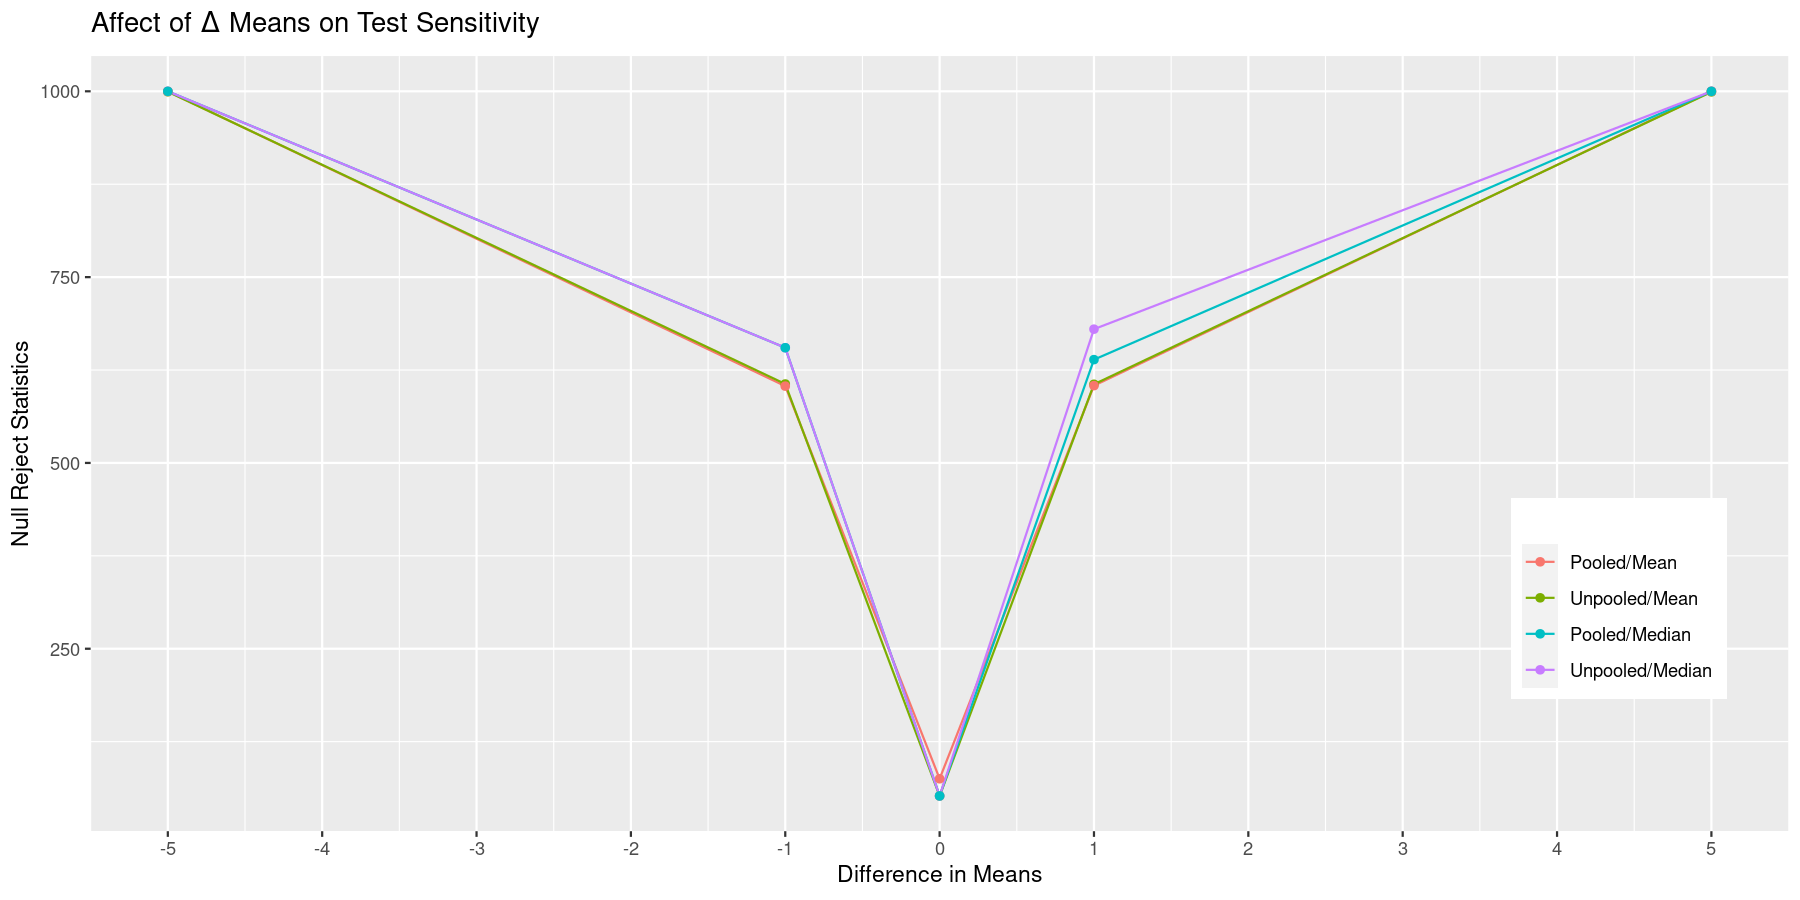

In [324]:
av_med_stats_by_diff %>% gather(key = "stat", value = "calc", avg_up:med_po) %>% 
                         ggplot() + geom_line(aes(x = diff, y = calc, color = stat)) + 
                                    geom_point(aes(x = diff, y = calc, color = stat)) + xlab("Difference in Means") +
                                    ylab("Null Reject Statistics") + ggtitle("Affect of" ~ Delta ~ "Means on Test Sensitivity") +
                                    scale_x_continuous(breaks = seq(-5, 5, 1)) + 
                                    scale_color_discrete(name = "",
                                                         labels = c("Pooled/Mean", "Unpooled/Mean", 
                                                                   "Pooled/Median", "Unpooled/Median")) +
                                    theme(legend.position = c(0.9, 0.3))
                                    

In [250]:
df_combo2 %>% mutate(comn = n1 + n2) %>% summary

   Test_Case          mu1          var1             n1             mu2   
 Min.   :  1.0   Min.   : 0   Min.   :1.000   Min.   :10.00   Min.   :5  
 1st Qu.: 34.5   1st Qu.: 4   1st Qu.:1.000   1st Qu.:10.00   1st Qu.:5  
 Median : 68.0   Median : 5   Median :4.000   Median :30.00   Median :5  
 Mean   : 68.0   Mean   : 5   Mean   :4.667   Mean   :36.67   Mean   :5  
 3rd Qu.:101.5   3rd Qu.: 6   3rd Qu.:9.000   3rd Qu.:70.00   3rd Qu.:5  
 Max.   :135.0   Max.   :10   Max.   :9.000   Max.   :70.00   Max.   :5  
      var2         n2        Test_Results_up  Test_Results_po       diff   
 Min.   :1   Min.   :10.00   Min.   :  40.0   Min.   :   1.0   Min.   :-5  
 1st Qu.:1   1st Qu.:10.00   1st Qu.: 269.5   1st Qu.: 251.5   1st Qu.:-1  
 Median :1   Median :30.00   Median : 784.0   Median : 838.0   Median : 0  
 Mean   :1   Mean   :36.67   Mean   : 652.5   Mean   : 656.4   Mean   : 0  
 3rd Qu.:1   3rd Qu.:70.00   3rd Qu.:1000.0   3rd Qu.:1000.0   3rd Qu.: 1  
 Max.   :1   Max.   :70.00

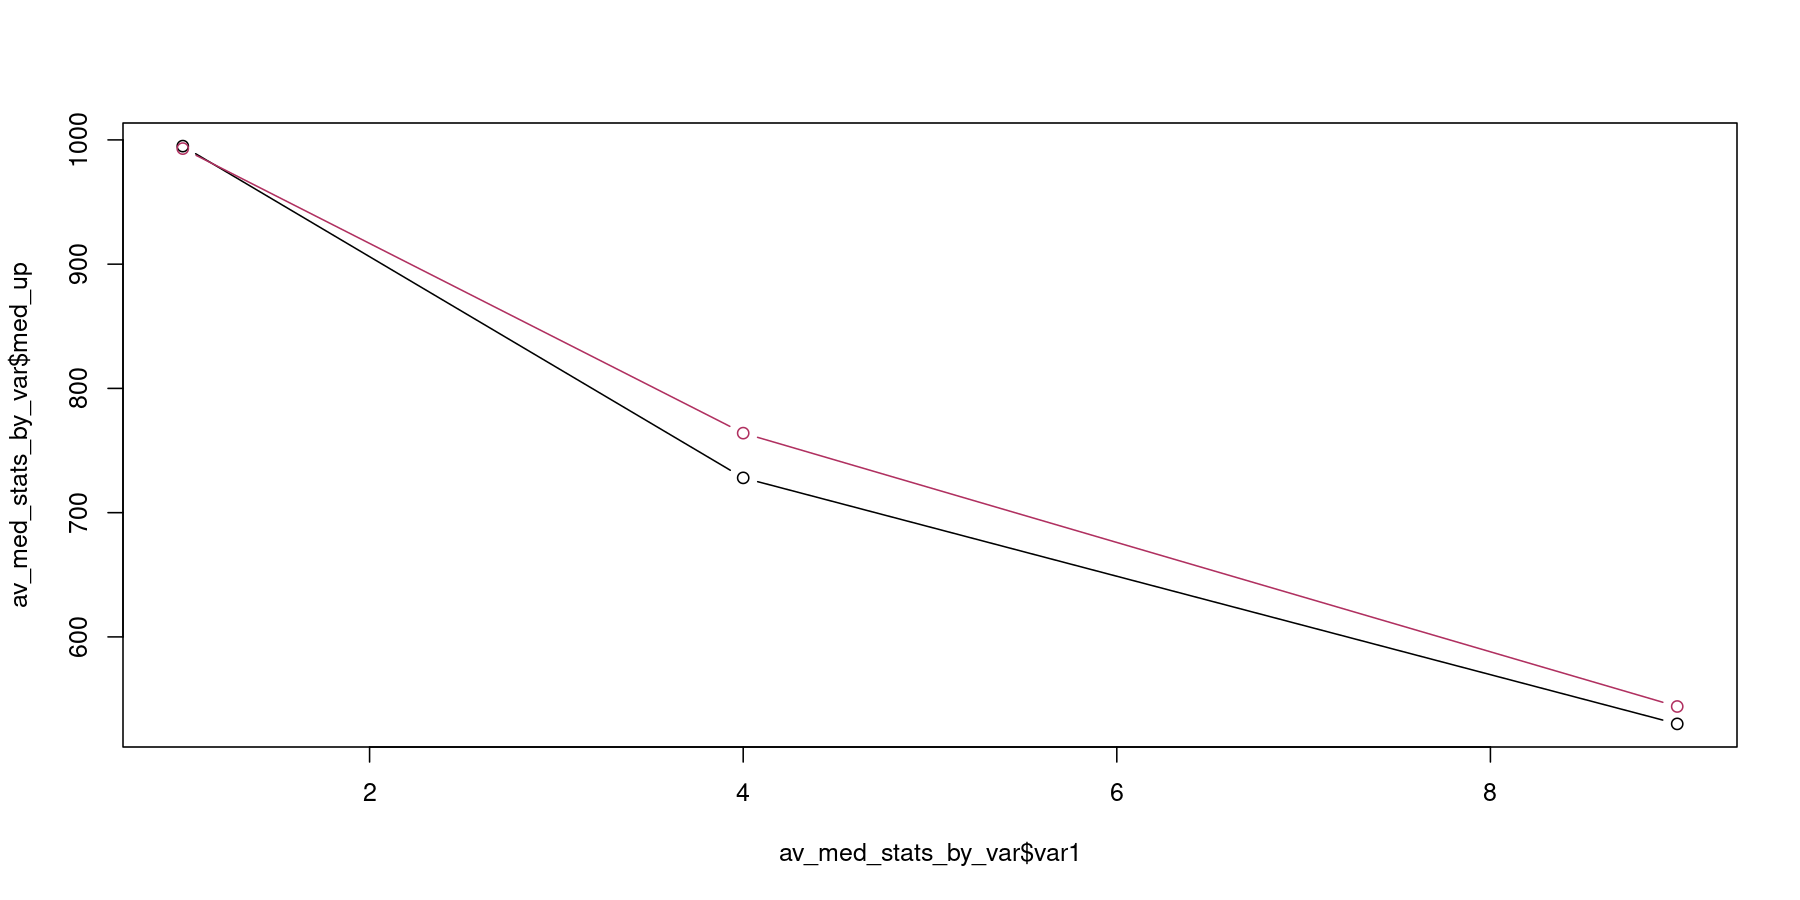

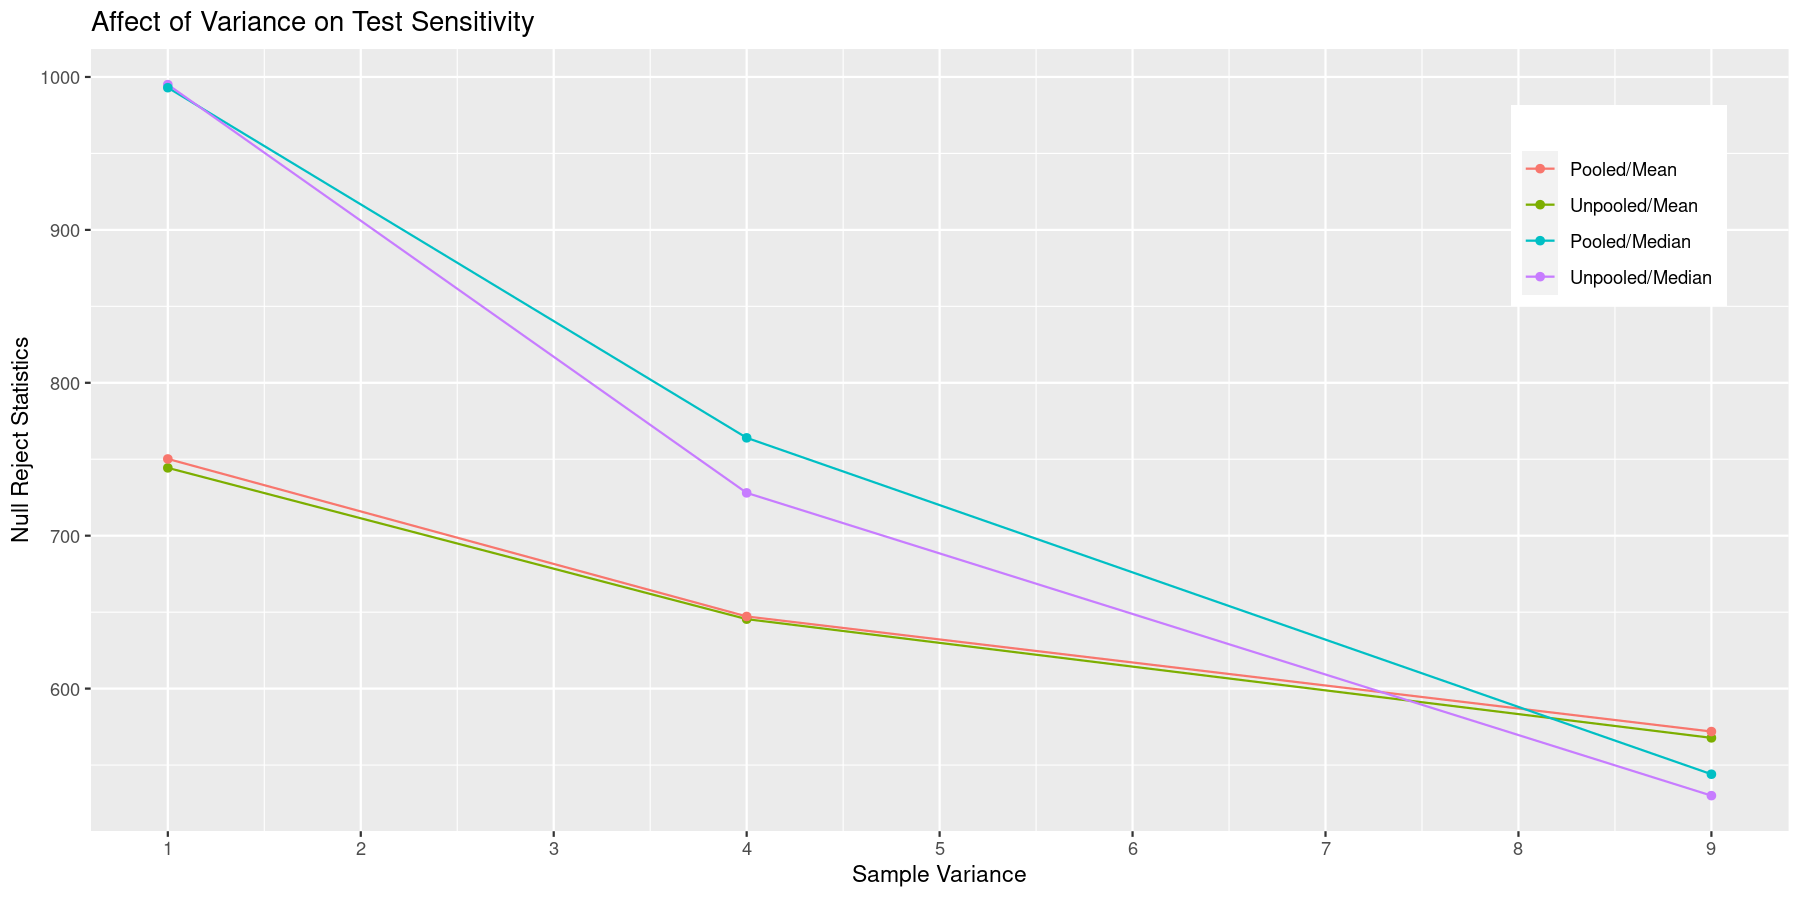

In [326]:
plot(av_med_stats_by_var$var1, av_med_stats_by_var$med_up, type = 'b')
points(av_med_stats_by_var$var1, av_med_stats_by_var$med_po, type = 'b', col = "maroon")


av_med_stats_by_var %>% gather(key = "stat", value = "calc", avg_up:med_po) %>% 
                         ggplot() + geom_line(aes(x = var1, y = calc, color = stat)) + 
                                    geom_point(aes(x = var1, y = calc, color = stat)) + xlab("Sample Variance") +
                                    ylab("Null Reject Statistics") + ggtitle("Affect of Variance on Test Sensitivity") +
                                    scale_x_continuous(breaks = seq(-5, 10, 1)) + 
                                    theme(legend.position = c(0.9, 0.8)) +
                                    scale_color_discrete(name = "",
                                                         labels = c("Pooled/Mean", 
                                                                    "Unpooled/Mean", 
                                                                    "Pooled/Median", 
                                                                    "Unpooled/Median"))

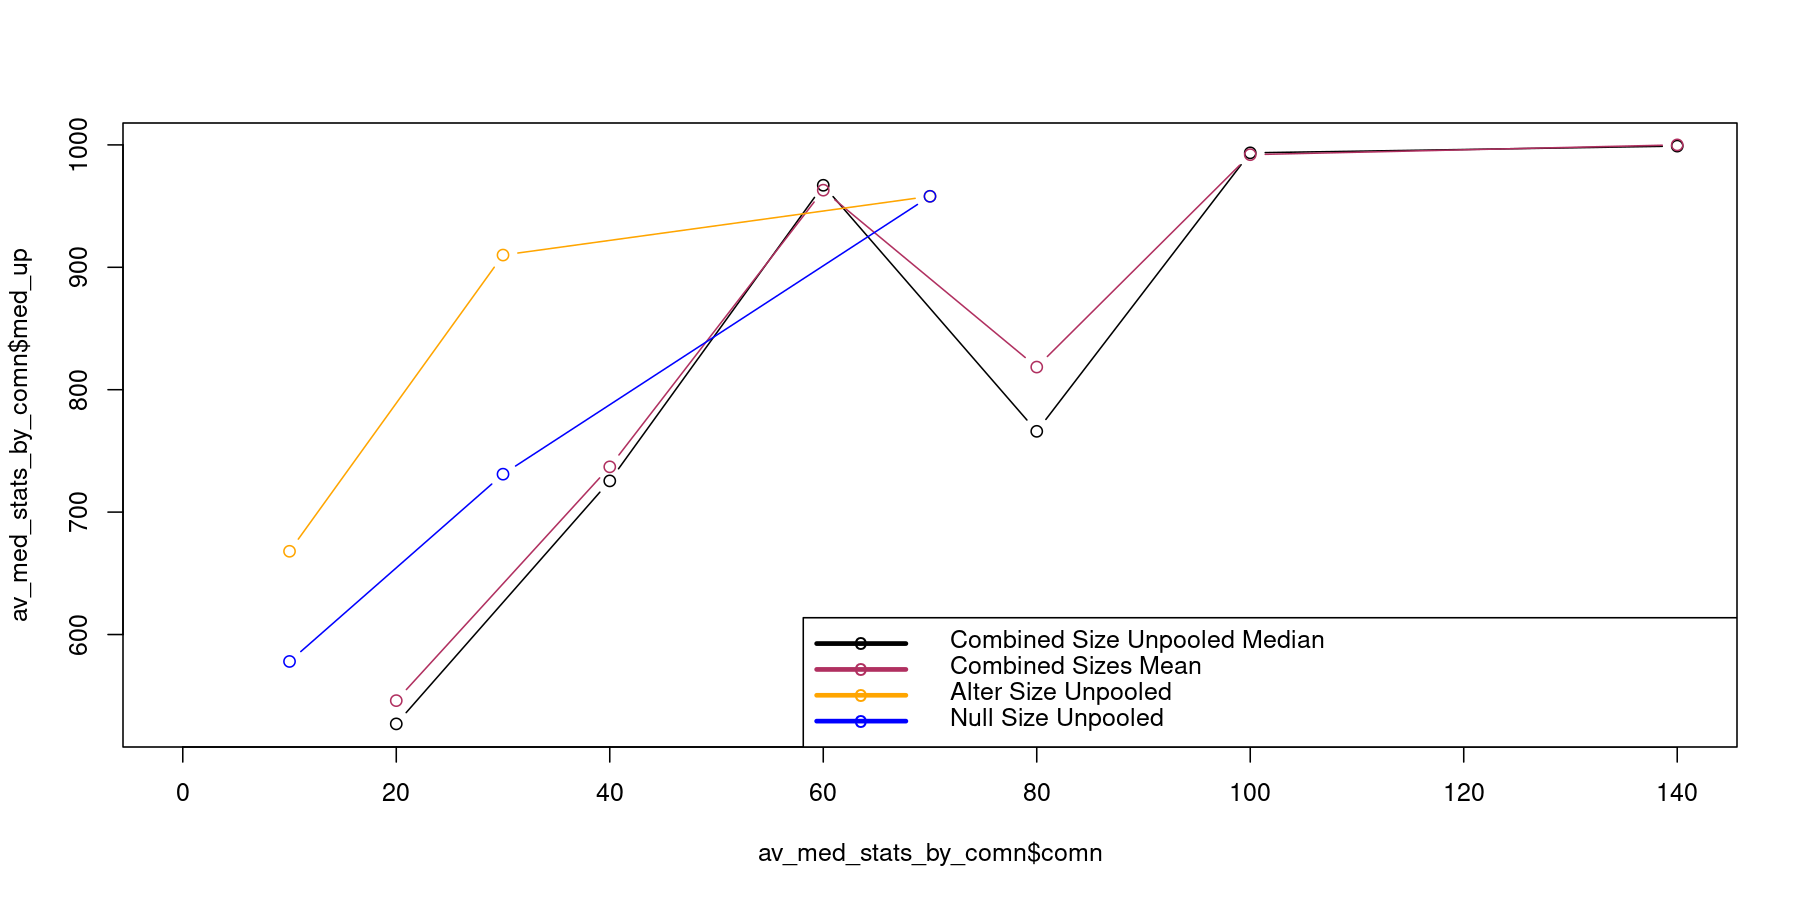

In [287]:
options(repr.plot.width = 12, repr.plot.height = 6, repr.plot.res = 150)

plot(av_med_stats_by_comn$comn, av_med_stats_by_comn$med_up, type = 'b', xlim = c(0, 140))
points(av_med_stats_by_comn$comn, av_med_stats_by_comn$med_po, type = 'b', col = "maroon")
points(av_med_stats_by_altn$n2, av_med_stats_by_altn$med_up, type = 'b', col = "orange")
points(av_med_stats_by_nulln$n1, av_med_stats_by_nulln$med_up, type = 'b', col = "blue")
legend("bottomright", legend = c("Combined Size Unpooled Median", "Combined Sizes Mean","Alter Size Unpooled", "Null Size Unpooled"), 
                                 col = c("black", "maroon", "orange", "blue"), lwd = 3, pch = "o")

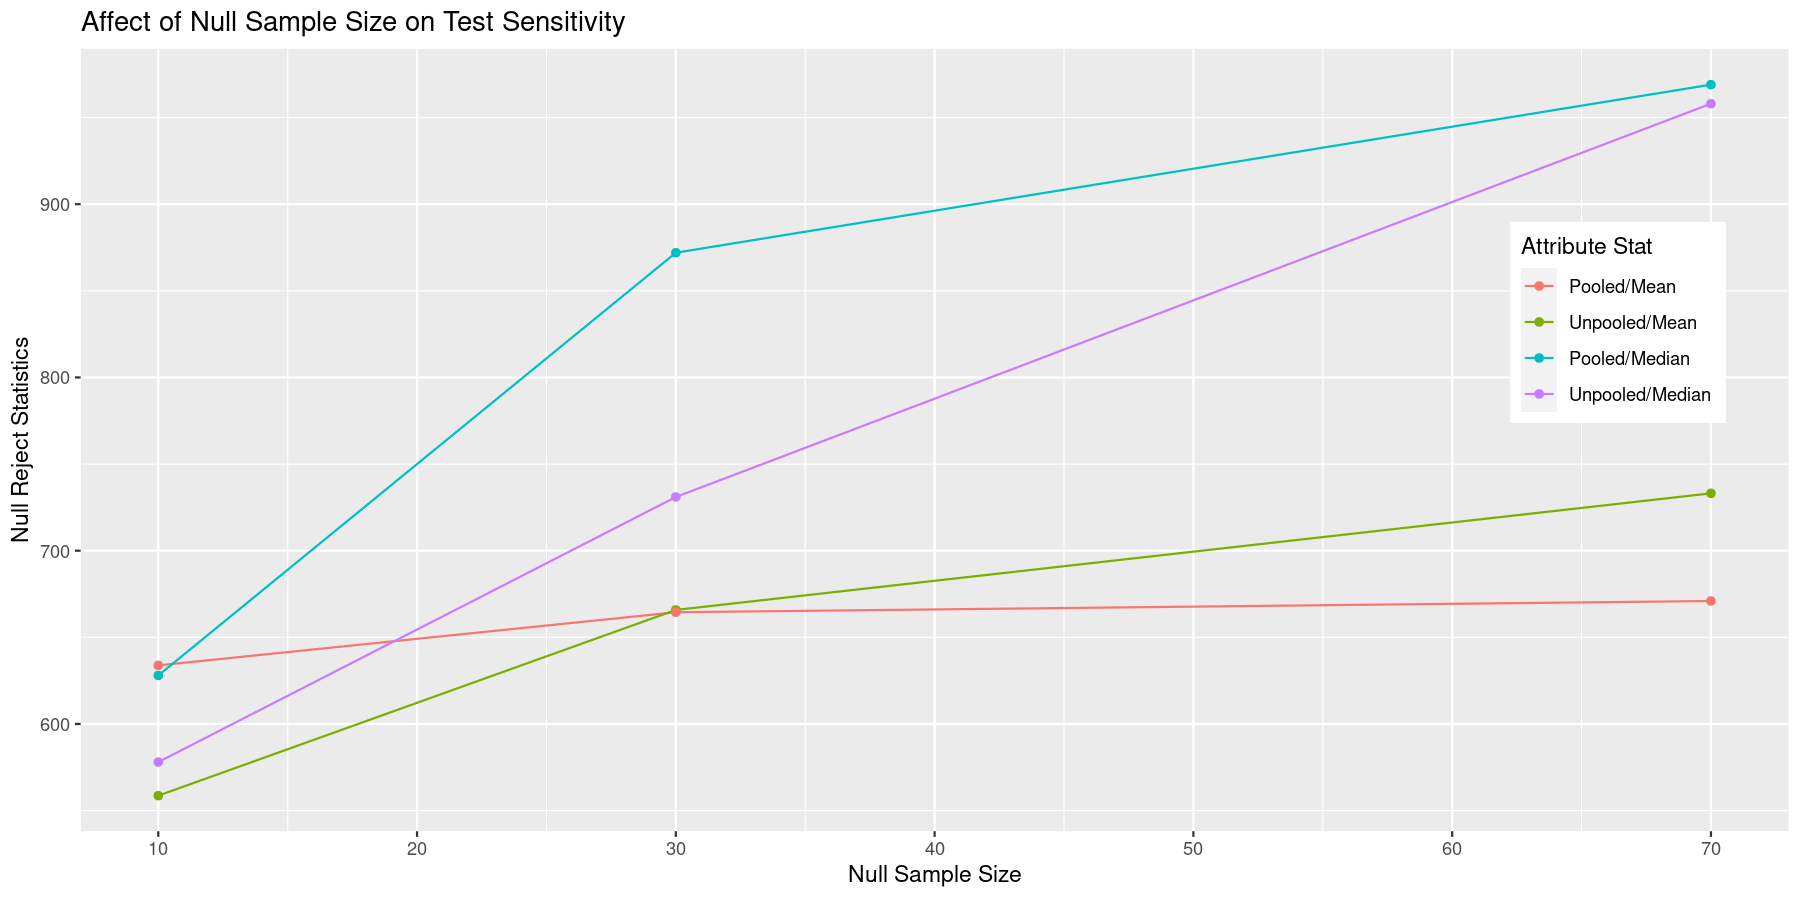

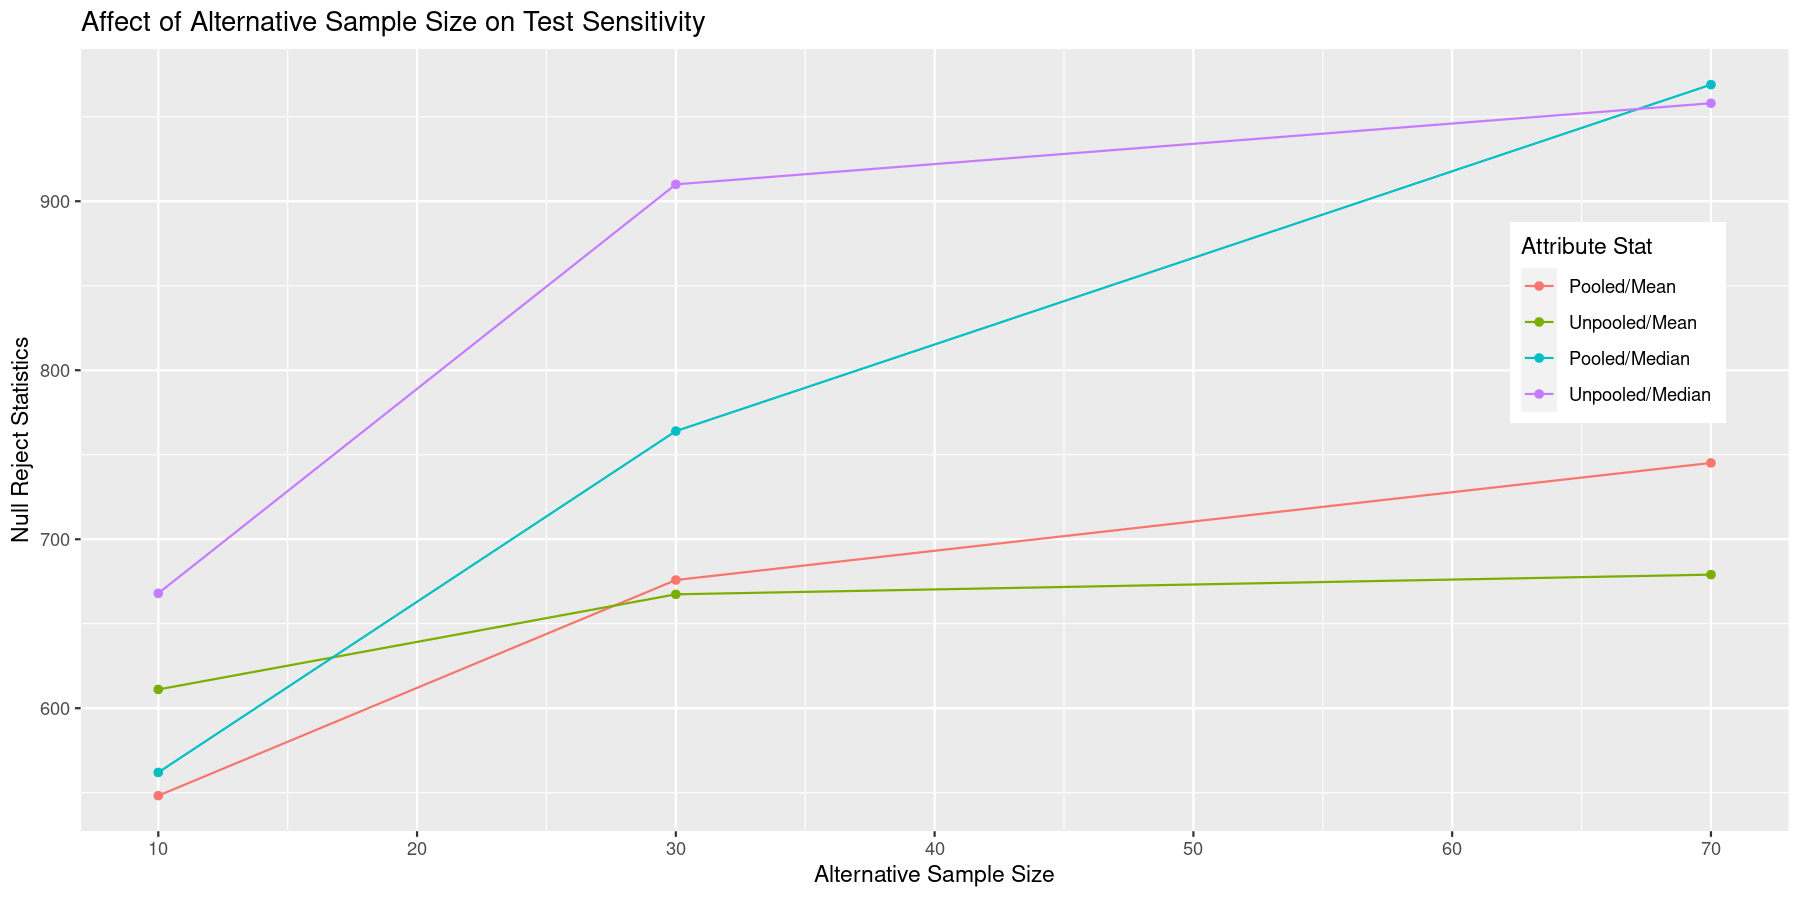

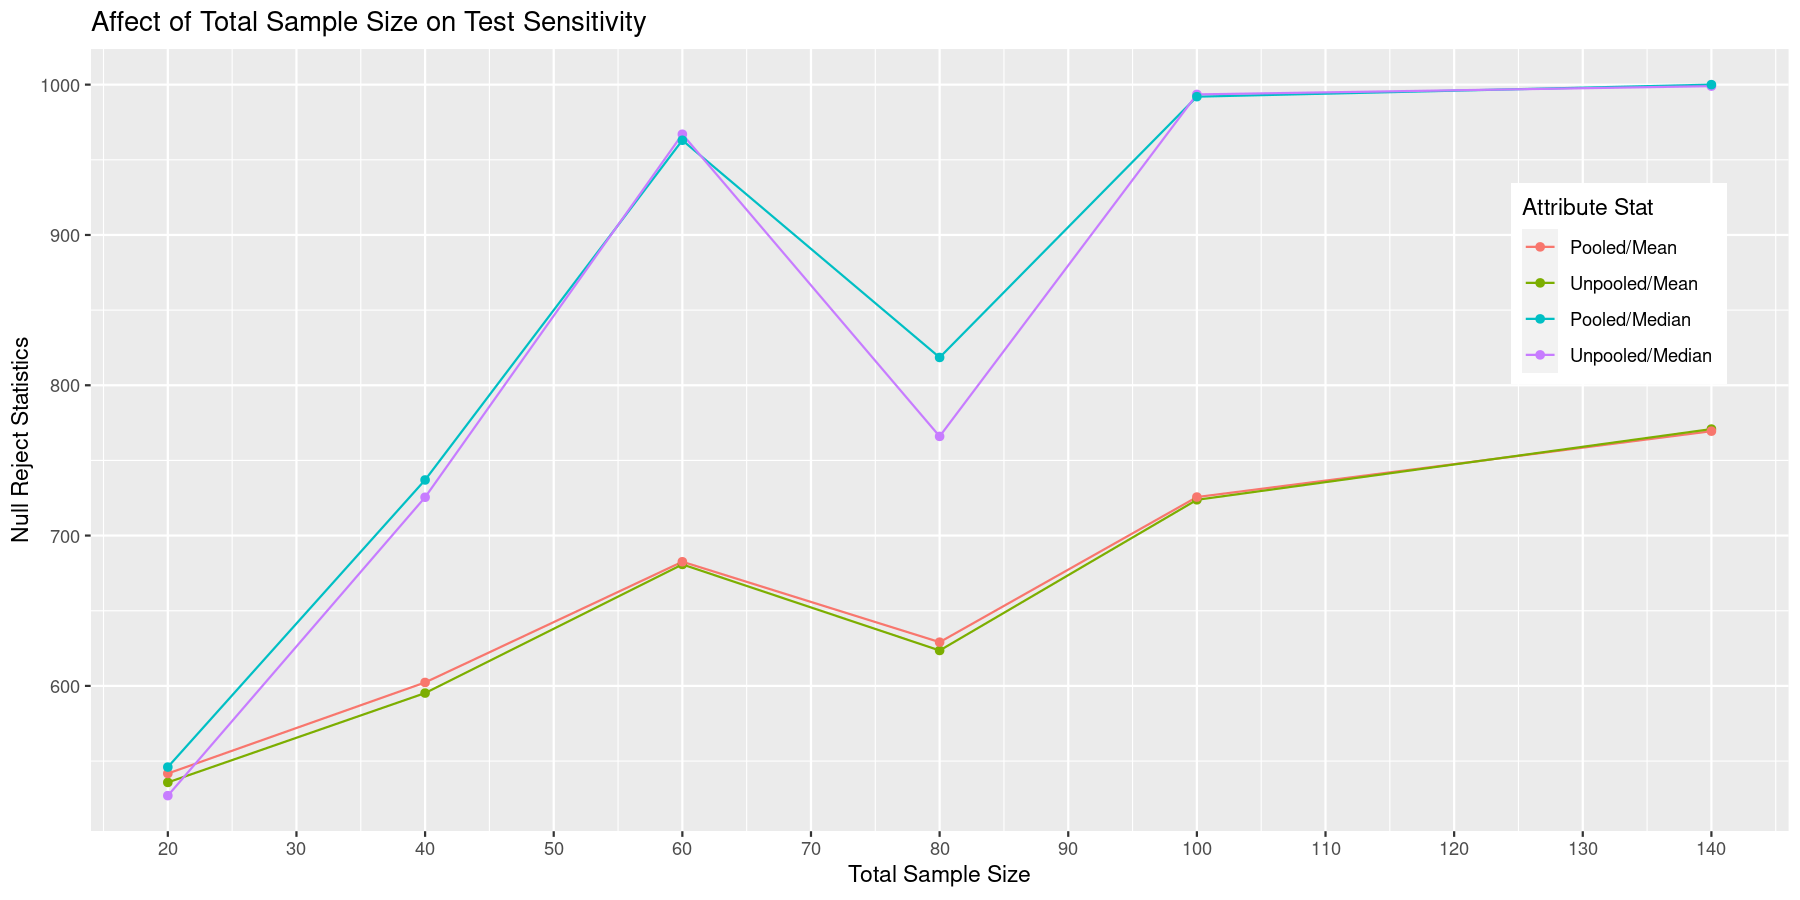

In [309]:
av_med_stats_by_nulln %>% gather(key = "stat", value = "calc", avg_up:med_po) %>% 
                          ggplot() + geom_line(aes(x = n1, y = calc, color = stat)) + 
                                     geom_point(aes(x = n1, y = calc, color = stat)) + 
                                     xlab("Null Sample Size") +
                                     ylab("Null Reject Statistics") + 
                                     ggtitle("Affect of Null Sample Size on Test Sensitivity") +
                                     scale_x_continuous(breaks = seq(10, 80, 10)) + 
                                     theme(legend.position = c(0.9, 0.65)) +
                                     scale_color_discrete(name = "Attribute Stat",
                                                         labels = c("Pooled/Mean", 
                                                                    "Unpooled/Mean", 
                                                                    "Pooled/Median", 
                                                                    "Unpooled/Median"))

av_med_stats_by_altn %>% gather(key = "stat", value = "calc", avg_up:med_po) %>% 
                          ggplot() + geom_line(aes(x = n2, y = calc, color = stat)) + 
                                     geom_point(aes(x = n2, y = calc, color = stat)) + 
                                     xlab("Alternative Sample Size") +
                                     ylab("Null Reject Statistics") + 
                                     ggtitle("Affect of Alternative Sample Size on Test Sensitivity") +
                                     scale_x_continuous(breaks = seq(10, 80, 10)) + 
                                     theme(legend.position = c(0.9, 0.65)) +
                                     scale_color_discrete(name = "Attribute Stat",
                                                         labels = c("Pooled/Mean", 
                                                                    "Unpooled/Mean", 
                                                                    "Pooled/Median", 
                                                                    "Unpooled/Median"))

av_med_stats_by_comn %>% gather(key = "stat", value = "calc", avg_up:med_po) %>% 
                          ggplot() + geom_line(aes(x = comn, y = calc, color = stat)) + 
                                     geom_point(aes(x = comn, y = calc, color = stat)) + xlab("Total Sample Size") +
                                     ylab("Null Reject Statistics") + ggtitle("Affect of Total Sample Size on Test Sensitivity") +
                                     scale_x_continuous(breaks = seq(10, 150, 10)) + 
                                     theme(legend.position = c(0.9, 0.7)) +
                                     scale_color_discrete(name = "Attribute Stat",
                                                         labels = c("Pooled/Mean", 
                                                                    "Unpooled/Mean", 
                                                                    "Pooled/Median", 
                                                                    "Unpooled/Median"))

In [312]:
df_combo2 %>% mutate(comn = n1 + n2, prop = n1 / (n1 + n2)) %>% group_by(comn, prop) %>% 
summarise(avg_up = mean(Test_Results_up), 
          med_up = median(Test_Results_up), 
          avg_po = mean(Test_Results_po), 
          med_po = median(Test_Results_po))

`summarise()` has grouped output by 'comn'. You can override using the `.groups` argument.



comn,prop,avg_up,med_up,avg_po,med_po
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
20,0.500,535.8000,527,541.7333,546
40,0.250,566.3333,728,652.1333,734
40,0.750,624.1333,723,552.4667,740
60,0.500,680.8000,967,682.6000,963
80,0.125,573.7333,756,707.6000,825
80,0.875,673.4000,776,550.6000,812
100,0.300,692.5333,992,758.4000,991
100,0.700,755.0667,997,692.8667,994
140,0.500,770.8667,999,769.4667,1000


In [313]:
df_combo2 %>% mutate(comn = n1 + n2, prop = n1 / (n1 + n2)) %>% head()

Test_Case,mu1,var1,n1,mu2,var2,n2,Test_Results_up,Test_Results_po,diff,comn,prop
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,1,10,5,1,10,1000,1000,-5,20,0.5
2,4,1,10,5,1,10,578,562,-1,20,0.5
3,5,1,10,5,1,10,54,39,0,20,0.5
4,6,1,10,5,1,10,527,546,1,20,0.5
5,10,1,10,5,1,10,1000,1000,5,20,0.5
6,0,4,10,5,1,10,1000,1000,-5,20,0.5


In [315]:
sd(df_data$sysBP)

[1] 22.89291

In [322]:
df_combo2 %>% filter(mu1 == 6, var1 == 4)

Test_Case,mu1,var1,n1,mu2,var2,n2,Test_Results_up,Test_Results_po,diff
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
9,6,4,10,5,1,10,271,265,1
24,6,4,30,5,1,10,549,281,1
39,6,4,70,5,1,10,668,244,1
54,6,4,10,5,1,30,273,523,1
69,6,4,30,5,1,30,680,665,1
84,6,4,70,5,1,30,910,764,1
99,6,4,10,5,1,70,297,623,1
114,6,4,30,5,1,70,714,872,1
129,6,4,70,5,1,70,951,948,1


In [354]:
pow_tab_9a <- test_results[[9]] %>% pull(Power) %>% summary() %>% unname() %>% matrix(ncol = 1)
pow_tab_9b <- test_results2[[9]] %>% pull(Power) %>% summary() %>% unname() %>% matrix(ncol = 1)
pow_tab_129a <- test_results[[129]] %>% pull(Power) %>% summary() %>% unname() %>% matrix(ncol = 1)
pow_tab_129b <- test_results2[[129]] %>% pull(Power) %>% summary() %>% unname() %>% matrix(ncol = 1)

d <- cbind(pow_tab_9a, pow_tab_9b, pow_tab_129a, pow_tab_129b)[2:5,]

colnames(d) = c("Test Case #9 (pooled)", "Test Case #9 (unequal)", "Test Case #129 (pooled)", "Test Case #129 (unequal)")
rownames(d) = c("1st Quartile", "Median", "Mean", "3rd Quartile")

knitr::kable(d)



|             | Test Case #9 (pooled)| Test Case #9 (unequal)| Test Case #129 (pooled)| Test Case #129 (unequal)|
|:------------|---------------------:|----------------------:|-----------------------:|------------------------:|
|1st Quartile |             0.1169414|              0.1211982|               0.8610788|                0.8635657|
|Median       |             0.2979222|              0.3113339|               0.9652580|                0.9587586|
|Mean         |             0.3793437|              0.3775096|               0.8953985|                0.8888423|
|3rd Quartile |             0.6114560|              0.5889342|               0.9947153|                0.9937438|

In [340]:
cbind(pow_tab_9a, pow_tab_9b, pow_tab_129a, pow_tab_129b)[2:5,]

0.1169414,0.1211982,0.8610788,0.8635657
0.2979222,0.3113339,0.9652580,0.9587586
0.3793437,0.3775096,0.8953985,0.8888423
0.6114560,0.5889342,0.9947153,0.9937438


In [355]:
df_power <- tibble(pull(test_results[[9]], Power), pull(test_results2[[9]], Power), pull(test_results[[129]], Power), pull(test_results2[[129]], Power))
colnames(df_power) = c("9P", "9U", "129P", "129U")

df_power %>% head()

9P,9U,129P,129U
<dbl>,<dbl>,<dbl>,<dbl>
0.46173293,0.39833523,0.9832023,0.8981655
0.05039432,0.10549079,0.9984601,0.6180604
0.98206512,0.30781028,0.9900677,0.9733474
0.06706217,0.16259849,0.9835537,0.1702976
0.77659020,0.08991847,0.9831416,0.9993877
0.06348796,0.75427722,0.9461102,0.9965820


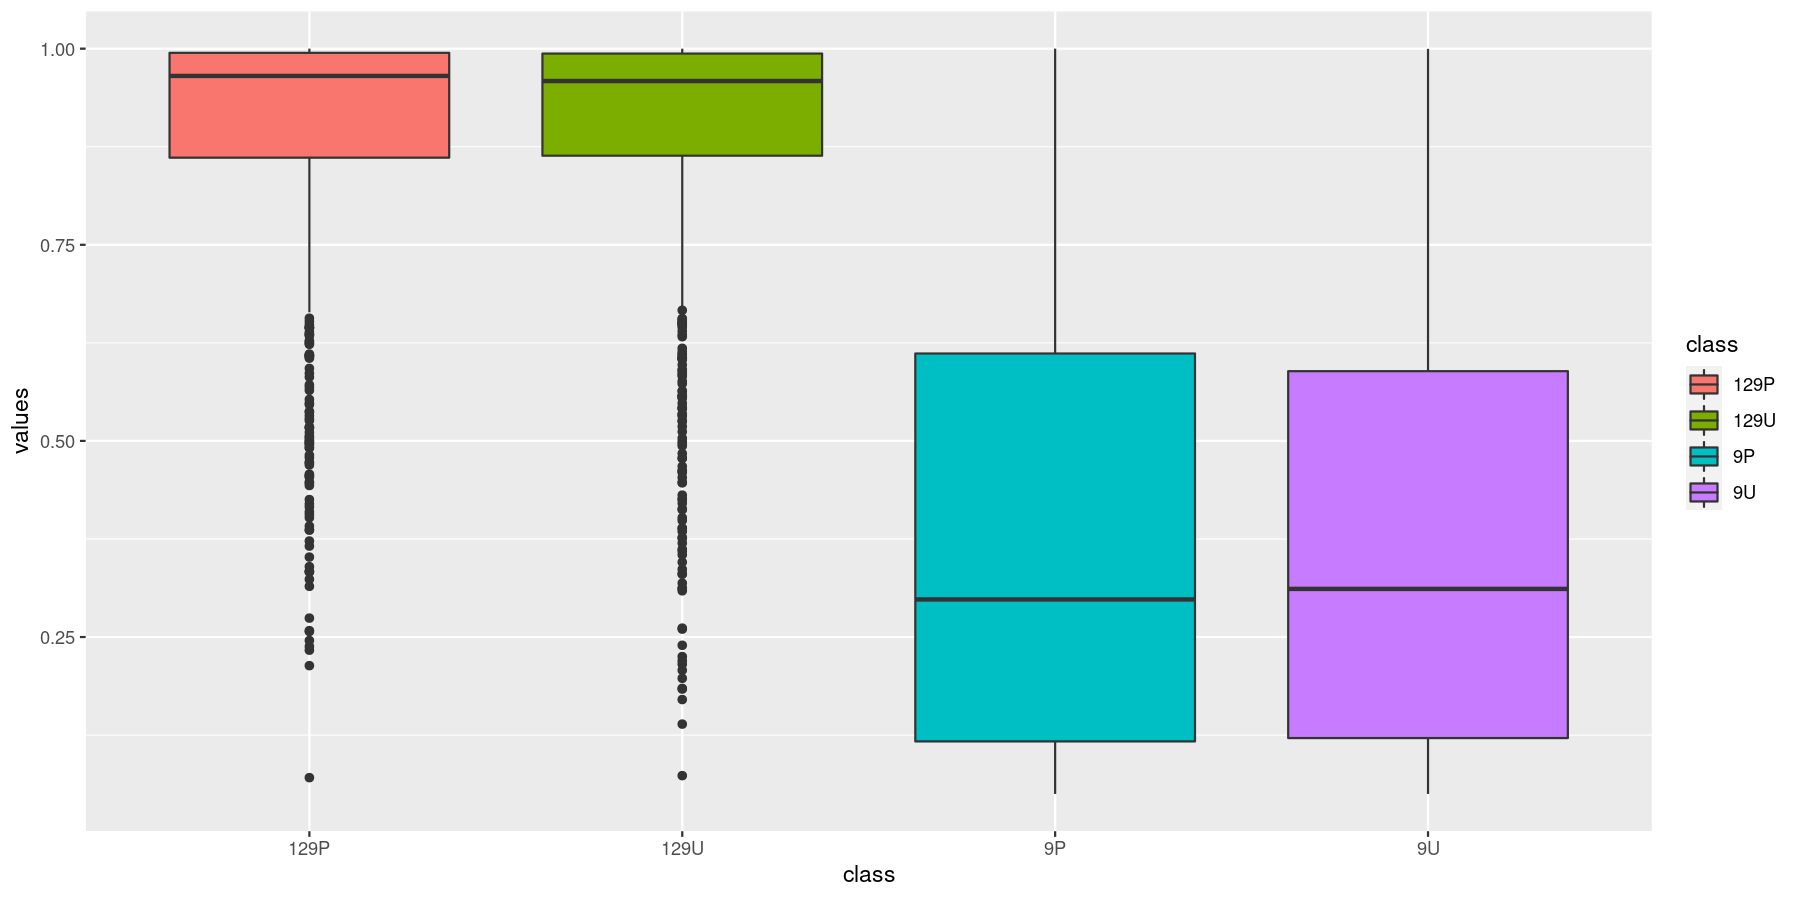

In [360]:
df_power %>% gather("class", "values", 1:4) %>% ggplot() + geom_boxplot(aes(x = class, y = values, fill = class))